# Module 8 Assignment 2: Leaf Classification
The goal of this project is to develop a multi-class Machine Learning model that classifies the leafs of multiple species

**Sachin Sharma**

**MSDS-422**

**08/11/2024**

## Management/Research Question
In layman’s terms, what is the management/research question of interest, and why would anyone care?

Requirements
1. Conduct your analysis using a cross-validation design.
2. Conduct EDA.
3. Build at least three CNN models based on hyperparameter tuning.
4. Evaluate goodness of fit metrics.
5. Build multi-class ROC and Precision / Recall graphs.
6. Once you have your best-performing models, classify the test data and submit it to Kaggle. Provide your Kaggle.com user name and screen snapshots of your scores.
7. Discuss your model’s performance.


### Import Libraries

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.python.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from keras_tuner import HyperParameters
from keras_tuner import RandomSearch
from keras.utils import to_categorical
import zipfile
from PIL import Image
import os
import random
import math
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings("ignore")

In [4]:
ls

input/  sample_data/


### EDA

In [5]:
train = pd.read_csv('./input/train.csv.zip')

In [6]:
train.head(3)

id                species   margin1   margin2   margin3   margin4  \
0   1            Acer_Opalus  0.007812  0.023438  0.023438  0.003906   
1   2  Pterocarya_Stenoptera  0.005859  0.000000  0.031250  0.015625   
2   3   Quercus_Hartwissiana  0.005859  0.009766  0.019531  0.007812   

    margin5   margin6   margin7  margin8  ...  texture55  texture56  \
0  0.011719  0.009766  0.027344      0.0  ...   0.007812        0.0   
1  0.025391  0.001953  0.019531      0.0  ...   0.000977        0.0   
2  0.003906  0.005859  0.068359      0.0  ...   0.154300        0.0   

   texture57  texture58  texture59  texture60  texture61  texture62  \
0   0.002930   0.002930   0.035156        0.0        0.0   0.004883   
1   0.000000   0.000977   0.023438        0.0        0.0   0.000977   
2   0.005859   0.000977   0.007812        0.0        0.0   0.000000   

   texture63  texture64  
0   0.000000   0.025391  
1   0.039062   0.022461  
2   0.020508   0.002930  

[3 rows x 194 columns]

In [7]:
train.columns

Index(['id', 'species', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5',
       'margin6', 'margin7', 'margin8',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=194)

In [8]:
train.describe()

id     margin1     margin2     margin3     margin4  \
count   990.000000  990.000000  990.000000  990.000000  990.000000   
mean    799.595960    0.017412    0.028539    0.031988    0.023280   
std     452.477568    0.019739    0.038855    0.025847    0.028411   
min       1.000000    0.000000    0.000000    0.000000    0.000000   
25%     415.250000    0.001953    0.001953    0.013672    0.005859   
50%     802.500000    0.009766    0.011719    0.025391    0.013672   
75%    1195.500000    0.025391    0.041016    0.044922    0.029297   
max    1584.000000    0.087891    0.205080    0.156250    0.169920   

          margin5     margin6     margin7     margin8     margin9  ...  \
count  990.000000  990.000000  990.000000  990.000000  990.000000  ...   
mean     0.014264    0.038579    0.019202    0.001083    0.007167  ...   
std      0.018390    0.052030    0.017511    0.002743    0.008933  ...   
min      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
25%      0.001953    0.000000    0.005859    0.000000    0.001953  ...   
50%      0.007812    0.015625    0.015625    0.000000    0.005859  ...   
75%      0.017578    0.056153    0.029297    0.000000    0.007812  ...   
max      0.111330    0.310550    0.091797    0.031250    0.076172  ...   

        texture55   texture56   texture57   texture58   texture59   texture60  \
count  990.000000  990.000000  990.000000  990.000000  990.000000  990.000000   
mean     0.036501    0.005024    0.015944    0.011586    0.016108    0.014017   
std      0.063403    0.019321    0.023214    0.025040    0.015335    0.060151   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000977    0.000000    0.004883    0.000000   
50%      0.004883    0.000000    0.005859    0.000977    0.012695    0.000000   
75%      0.043701    0.000000    0.022217    0.009766    0.021484    0.000000   
max      0.429690    0.202150    0.172850    0.200200    0.106450    0.578130   

        texture61   texture62   texture63   texture64  
count  990.000000  990.000000  990.000000  990.000000  
mean     0.002688    0.020291    0.008989    0.019420  
std      0.011415    0.039040    0.013791    0.022768  
min      0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000    0.000977  
50%      0.000000    0.003906    0.002930    0.011719  
75%      0.000000    0.023438    0.012695    0.029297  
max      0.151370    0.375980    0.086914    0.141600  

[8 rows x 193 columns]

In [9]:
# Identifying the column names
margin_cols = train.columns[train.columns.str.contains('margin')].size
shape_cols = train.columns[train.columns.str.contains('shape')].size
texture_cols = train.columns[train.columns.str.contains('texture')].size

print('Number of columns with "margin" in their names: ', margin_cols)
print('Number of columns with "shape" in their names: ', shape_cols)
print('Number of columns with "texture" in their names: ', texture_cols)

Number of columns with "margin" in their names:  64
Number of columns with "shape" in their names:  64
Number of columns with "texture" in their names:  64


In [10]:
#check for duplicate values
print(f'{train.duplicated().sum()} duplicated item')

0 duplicated item


In [11]:
# Sample asociated variables count
print(f'{train.shape[0]} samples for {train.shape[1]} variables')

990 samples for 194 variables


In [12]:
# Count the number of species
num_classes = train['species'].unique().shape[0]
num_classes

99

In [13]:
classes = train['species'].unique().tolist()
classes

['Acer_Opalus',
 'Pterocarya_Stenoptera',
 'Quercus_Hartwissiana',
 'Tilia_Tomentosa',
 'Quercus_Variabilis',
 'Magnolia_Salicifolia',
 'Quercus_Canariensis',
 'Quercus_Rubra',
 'Quercus_Brantii',
 'Salix_Fragilis',
 'Zelkova_Serrata',
 'Betula_Austrosinensis',
 'Quercus_Pontica',
 'Quercus_Afares',
 'Quercus_Coccifera',
 'Fagus_Sylvatica',
 'Phildelphus',
 'Acer_Palmatum',
 'Quercus_Pubescens',
 'Populus_Adenopoda',
 'Quercus_Trojana',
 'Alnus_Sieboldiana',
 'Quercus_Ilex',
 'Arundinaria_Simonii',
 'Acer_Platanoids',
 'Quercus_Phillyraeoides',
 'Cornus_Chinensis',
 'Liriodendron_Tulipifera',
 'Cytisus_Battandieri',
 'Rhododendron_x_Russellianum',
 'Alnus_Rubra',
 'Eucalyptus_Glaucescens',
 'Cercis_Siliquastrum',
 'Cotinus_Coggygria',
 'Celtis_Koraiensis',
 'Quercus_Crassifolia',
 'Quercus_Kewensis',
 'Cornus_Controversa',
 'Quercus_Pyrenaica',
 'Callicarpa_Bodinieri',
 'Quercus_Alnifolia',
 'Acer_Saccharinum',
 'Prunus_X_Shmittii',
 'Prunus_Avium',
 'Quercus_Greggii',
 'Quercus_Suber'

In [14]:
# Count the number of datapoints for every species
train['species'].value_counts()

species
Acer_Opalus                    10
Crataegus_Monogyna             10
Acer_Mono                      10
Magnolia_Heptapeta             10
Acer_Capillipes                10
                               ..
Alnus_Rubra                    10
Rhododendron_x_Russellianum    10
Cytisus_Battandieri            10
Liriodendron_Tulipifera        10
Sorbus_Aria                    10
Name: count, Length: 99, dtype: int64

In [15]:
# read the images file
file_name = "./input/images.zip"

# opening the zip file in READ mode
with zipfile.ZipFile(file_name, 'r') as zipobj:
    # get a list of all archived file names from the zip
    image_names= zipobj.namelist()
    # use a list comprehension to get a list of image filenames (with .jpg extensions)
    list_of_image_filenames = [filename for filename in image_names if filename.endswith(('.jpg'))]

    print(f'The number of images in the zip file is: {len(list_of_image_filenames)}')

The number of images in the zip file is: 1584


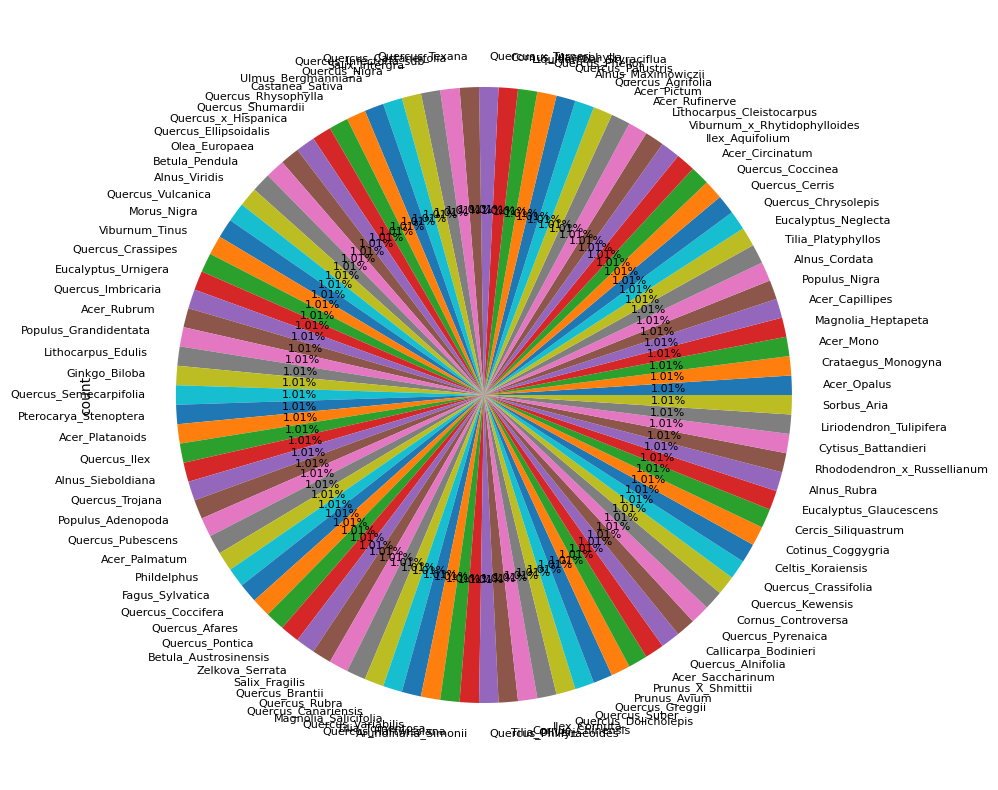

In [16]:
plt.figure(figsize =(10, 10))
train['species'].value_counts().plot.pie(autopct='%1.2f%%', textprops={'fontsize': 8});

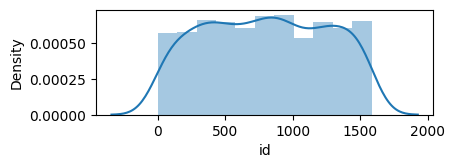

In [17]:
plt.figure(figsize = (20, 80))

columns = 4
i = 0

for col in train.select_dtypes('int'):
    plt.subplot(int(train.shape[1] / columns + 1), columns, i + 1)
    sns.distplot(train[col])
    i += 1

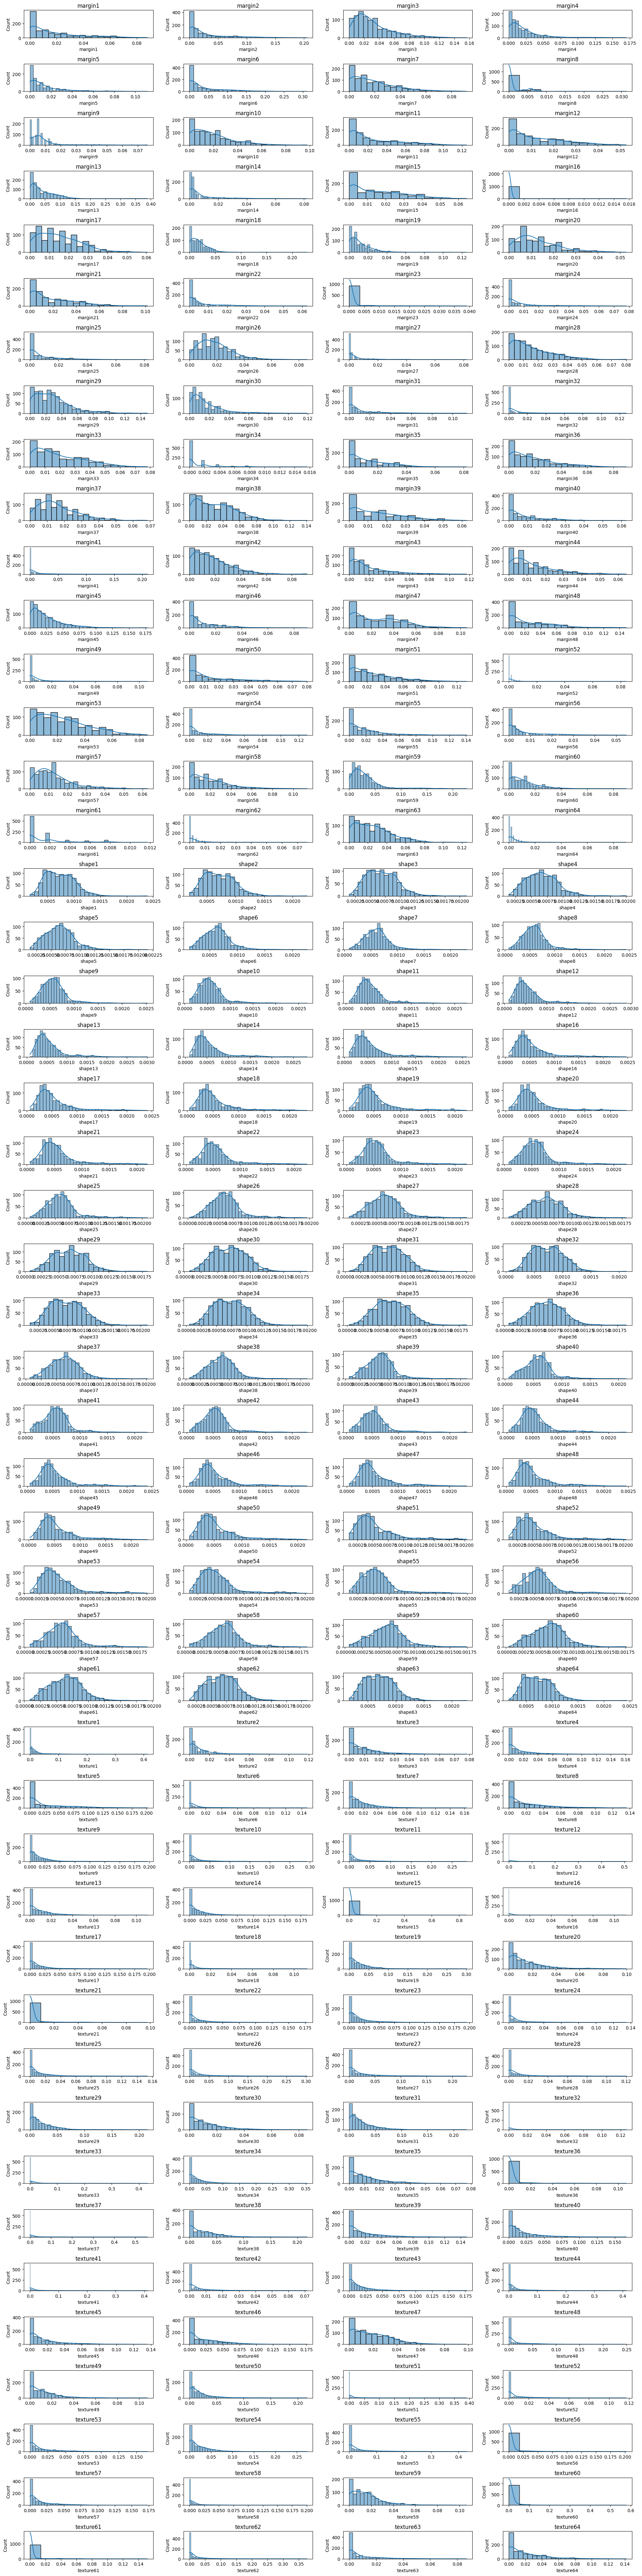

In [18]:
plt.figure(figsize=(20, 80))

columns = 4
i = 0
num_plots = len(train.select_dtypes('float').columns)
rows = math.ceil(num_plots / columns)

for col in train.select_dtypes('float'):
    plt.subplot(rows, columns, i + 1)
    sns.histplot(train[col], kde=True)  # `sns.histplot` with `kde=True` provides a similar effect as `distplot`
    plt.title(col)
    i += 1

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

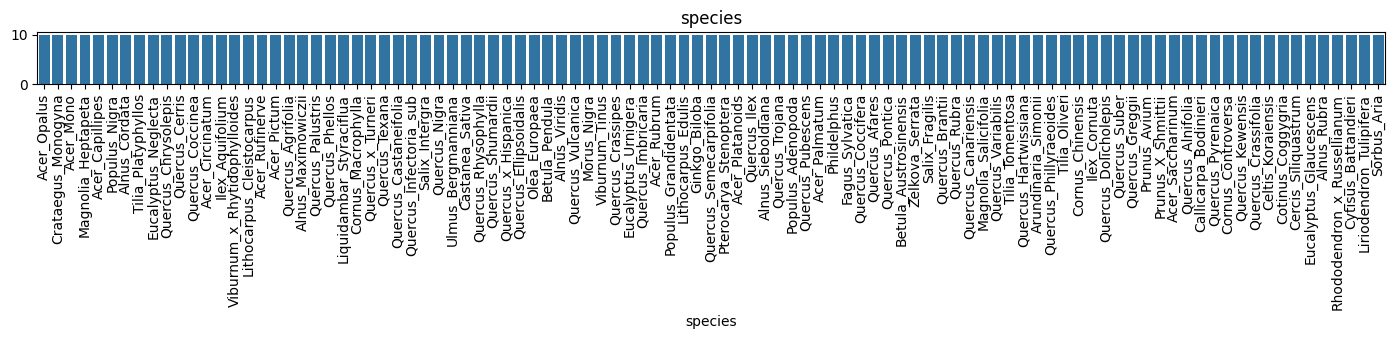

In [19]:
plt.figure(figsize=(80, 20))

columns = 4
i = 0

for col in train.select_dtypes('object'):
    value_counts = train[col].value_counts()
    num_values = len(value_counts)
    plt.subplot(int(num_values / columns + 1), columns, i + 1)
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.xticks(rotation=90)
    plt.title(col)
    i += 1

plt.tight_layout()
plt.show()

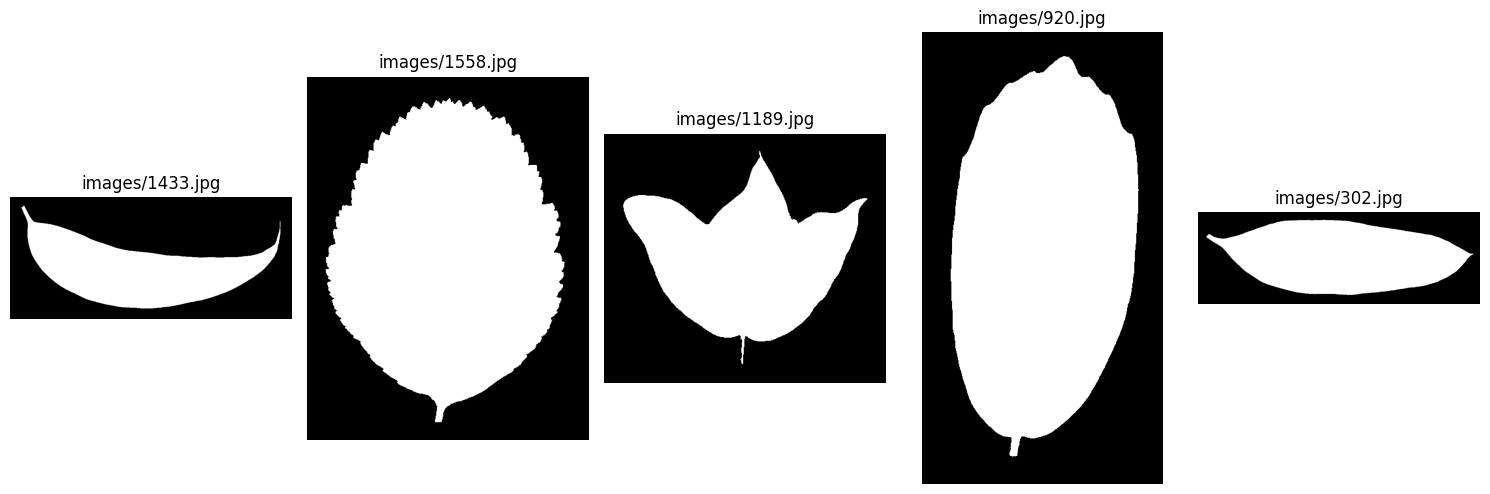

In [20]:
# Match the image filenames in the zip file with the ids in the train_df DataFrame
matched_images = [img for img in image_names if any(str(id) in img for id in train['id'])]

# Randomly pick 5 images
random.seed(4)
five_images = random.sample(matched_images, 5)

# Create a figure to display images in the same row
plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

# Display the images
for i, img_name in enumerate(five_images):
    with zipfile.ZipFile('./input/images.zip', 'r') as myzip:
        with myzip.open(img_name) as myfile:
            img = Image.open(myfile)
            plt.subplot(1, 5, i + 1)  # 1 row, 5 columns
            plt.imshow(img, cmap='gray')
            plt.title(img_name)
            plt.axis('off')  # Hide the axis

plt.tight_layout()  # Adjust layout
plt.show()

### Pre Model Buidling

In [21]:
# Read the input files
train_df = pd.read_csv('./input/train.csv.zip')

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Copy the original DataFrame
processed_df = train_df.copy()

# Initialize the encoder
le = LabelEncoder()

# Encode the 'species' column
processed_df['species'] = le.fit_transform(processed_df['species'])

# Initialize the scaler
scaler = MinMaxScaler()

# Scale numeric columns. Exclude 'id' and 'species' from being scaled
numeric_cols = processed_df.columns.drop(['id', 'species'])
processed_df[numeric_cols] = scaler.fit_transform(processed_df[numeric_cols])

# Split the DataFrame into features and target
X = processed_df.drop(columns=['id', 'species'])
y = processed_df['species']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Print the first 5 rows of the processed DataFrame
processed_df.head()

id  species   margin1   margin2   margin3   margin4   margin5   margin6  \
0   1        3  0.088883  0.114287  0.150003  0.022987  0.105264  0.031447   
1   2       49  0.066662  0.000000  0.200000  0.091955  0.228070  0.006289   
2   3       65  0.066662  0.047620  0.124998  0.045975  0.035085  0.018867   
3   5       94  0.000000  0.019046  0.150003  0.034481  0.192976  0.062892   
4   6       84  0.066662  0.019046  0.312499  0.057474  0.122806  0.050314   

    margin7  margin8  ...  texture55  texture56  texture57  texture58  \
0  0.297875      0.0  ...   0.018181   0.000000   0.016951   0.014635   
1  0.212763      0.0  ...   0.002274   0.000000   0.000000   0.004880   
2  0.744676      0.0  ...   0.359096   0.000000   0.033896   0.004880   
3  0.255324      0.0  ...   0.000000   0.004833   0.000000   0.000000   
4  0.063826      0.0  ...   0.224999   0.000000   0.124293   0.000000   

   texture59  texture60  texture61  texture62  texture63  texture64  
0   0.330258        0.0        0.0   0.012987   0.000000   0.179315  
1   0.220178        0.0        0.0   0.002599   0.449433   0.158623  
2   0.073387        0.0        0.0   0.000000   0.235957   0.020692  
3   0.192654        0.0        0.0   0.046752   0.000000   0.337938  
4   0.000000        0.0        0.0   0.000000   0.000000   0.220692  

[5 rows x 194 columns]

In [23]:
# Reshape the data
def reshape_for_cnn(X, n_channels):
    dim = int(np.sqrt(X.shape[1] // n_channels))
    return X.values.reshape(-1, dim, dim, n_channels)

# Define number of channels
n_channels = 3  # margin, shape, texture

# Reshape training, validation data
X_train_reshaped = reshape_for_cnn(X_train, n_channels)
X_val_reshaped = reshape_for_cnn(X_val, n_channels)

In [24]:
# To ensure reproducibility in the experiments, we fix the random seed for all components in the code
seed_value=1

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set Python built-in pseudorandom generator at a fixed value
random.seed(seed_value)

# 3. Set NumPy pseudorandom generator at a fixed value
np.random.seed(seed_value)

# 4. Set TensorFlow pseudorandom generator at a fixed value
tf.random.set_seed(seed_value)

### Modeling

#### Model 1 : Simple CNN Model with 1 Convolutional Layer
A basic model with 1 convolutional layer, 1 pooling layer, and 1 fully connected layer, designed for simplicity and speed.

In [25]:
class SimpleCNN:
    def __init__(self, num_class):
        self.num_class = num_class

    def build(self, hp: HyperParameters):
        model = Sequential()
        model.add(Conv2D(
            filters=hp.Choice('conv_filters', values=[32, 64]),  # Adjustable number of filters
            kernel_size=(3, 3),
            padding='same',
            activation='relu',
            input_shape=(8, 8, 3)
        ))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(hp.Choice('dense_units', values=[64, 128]), activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.num_class, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        return model

hypermodel = SimpleCNN(num_class=num_classes)

# Cross Validation Approach
'''Utilizing a RandomSearch tuner to identify the optimal hyperparameters for a model,
as opposed to manually selecting hyperparameters for testing a few models, presents a more efficient
and effective method. This approach systematically explores a wide range of hyperparameter combinations
across 20 trials, each with 5 executions to ensure reliability in finding the best set.
By automating the search, it significantly increases the likelihood of discovering an optimal
configuration that might not be evident through manual selection. This method leverages computational
power to evaluate numerous possibilities in a structured manner, thereby reducing human bias and oversight.
It leads to potentially higher model accuracy and performance by rigorously testing a broad spectrum
of configurations, ensuring that the final model, trained with the best hyperparameters, is highly tuned
to the specific characteristics of the dataset.'''

# Searching for the best hyperparameters
tuner = RandomSearch(
    hypermodel.build,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=5,
    directory='random_search',
    project_name='leaf_classification'
)
tuner.search(
    x=X_train_reshaped,
    y=to_categorical(y_train, num_classes=num_classes),
    epochs=10,
    validation_split=0.2
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train_reshaped,
    to_categorical(y_train, num_classes=num_classes),
    epochs=10,
    validation_data=(X_val_reshaped, to_categorical(y_val, num_classes=num_classes))
)

Trial 4 Complete [00h 00m 38s]
val_accuracy: 0.5886792540550232

Best val_accuracy So Far: 0.7622641563415528
Total elapsed time: 00h 03m 06s
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.0150 - loss: 4.5908 - val_accuracy: 0.1010 - val_loss: 4.5005
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0856 - loss: 4.4168 - val_accuracy: 0.0909 - val_loss: 4.2416
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1058 - loss: 4.0645 - val_accuracy: 0.2121 - val_loss: 3.7666
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1919 - loss: 3.6031 - val_accuracy: 0.3889 - val_loss: 3.1838
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2991 - loss: 3.0247 - val_accuracy: 0.5404 - val_loss: 2.5760
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4009 - loss: 2.5429 - val_accuracy: 0.6515 - val_loss: 2.0151
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4498 - loss: 2.1401 - val_accuracy: 

In [26]:
test_loss, test_acc = best_model.evaluate(X_val_reshaped, to_categorical(y_val, num_classes=num_classes))
print(f"Validation accuracy: {test_acc*100:.2f}%")
print(f"Validation loss: {test_loss:.4f}")


model_config = best_model.get_config()
model_layers = model_config['layers']

# Convolutional layer
conv_layer_config = next(layer for layer in model_layers if layer['class_name'] == 'Conv2D')
conv_filters = conv_layer_config['config'].get('filters')

# Dense layers
dense_layers_config = [layer for layer in model_layers if layer['class_name'] == 'Dense']
dense_units = [config['config'].get('units') for config in dense_layers_config]

# Dropout layer
dropout_layer_config = next(layer for layer in model_layers if layer['class_name'] == 'Dropout')
dropout_rate = dropout_layer_config['config'].get('rate')

# L2 Regularization
l2_reg_config = None  # Initialize to None
for config in dense_layers_config:
    kernel_regularizer = config['config'].get('kernel_regularizer')
    if kernel_regularizer is not None:
        l2_reg_config = kernel_regularizer.get_config()
        break  # Break once we find the first regularizer

l2_regularization = l2_reg_config['l2'] if l2_reg_config else None
# l2_reg_config = next(config['config'].get('kernel_regularizer', {}) for config in dense_layers_config if config['config'].get('kernel_regularizer'))
# l2_regularization = l2_reg_config.get('l2') if l2_reg_config else None

# These are some of the most important hyperparameters in this model.
print(f"Conv2D filters: {conv_filters}")
print(f"Dense units: {dense_units}")
print(f"Dropout rate: {dropout_rate}")
print(f"L2 regularization: {l2_regularization}")

# Printing the learning_rate
optimizer_config = best_model.optimizer.get_config()
learning_rate = optimizer_config.get('learning_rate')

print("The learning rate for the best model is:", learning_rate)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8889 - loss: 0.7767 
Validation accuracy: 88.38%
Validation loss: 0.7884
Conv2D filters: 64
Dense units: [128, 99]
Dropout rate: 0.5
L2 regularization: None
The learning rate for the best model is: 0.0010000000474974513


##### Plotting the Multi-Class ROC and Precision / Recall Graphs

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


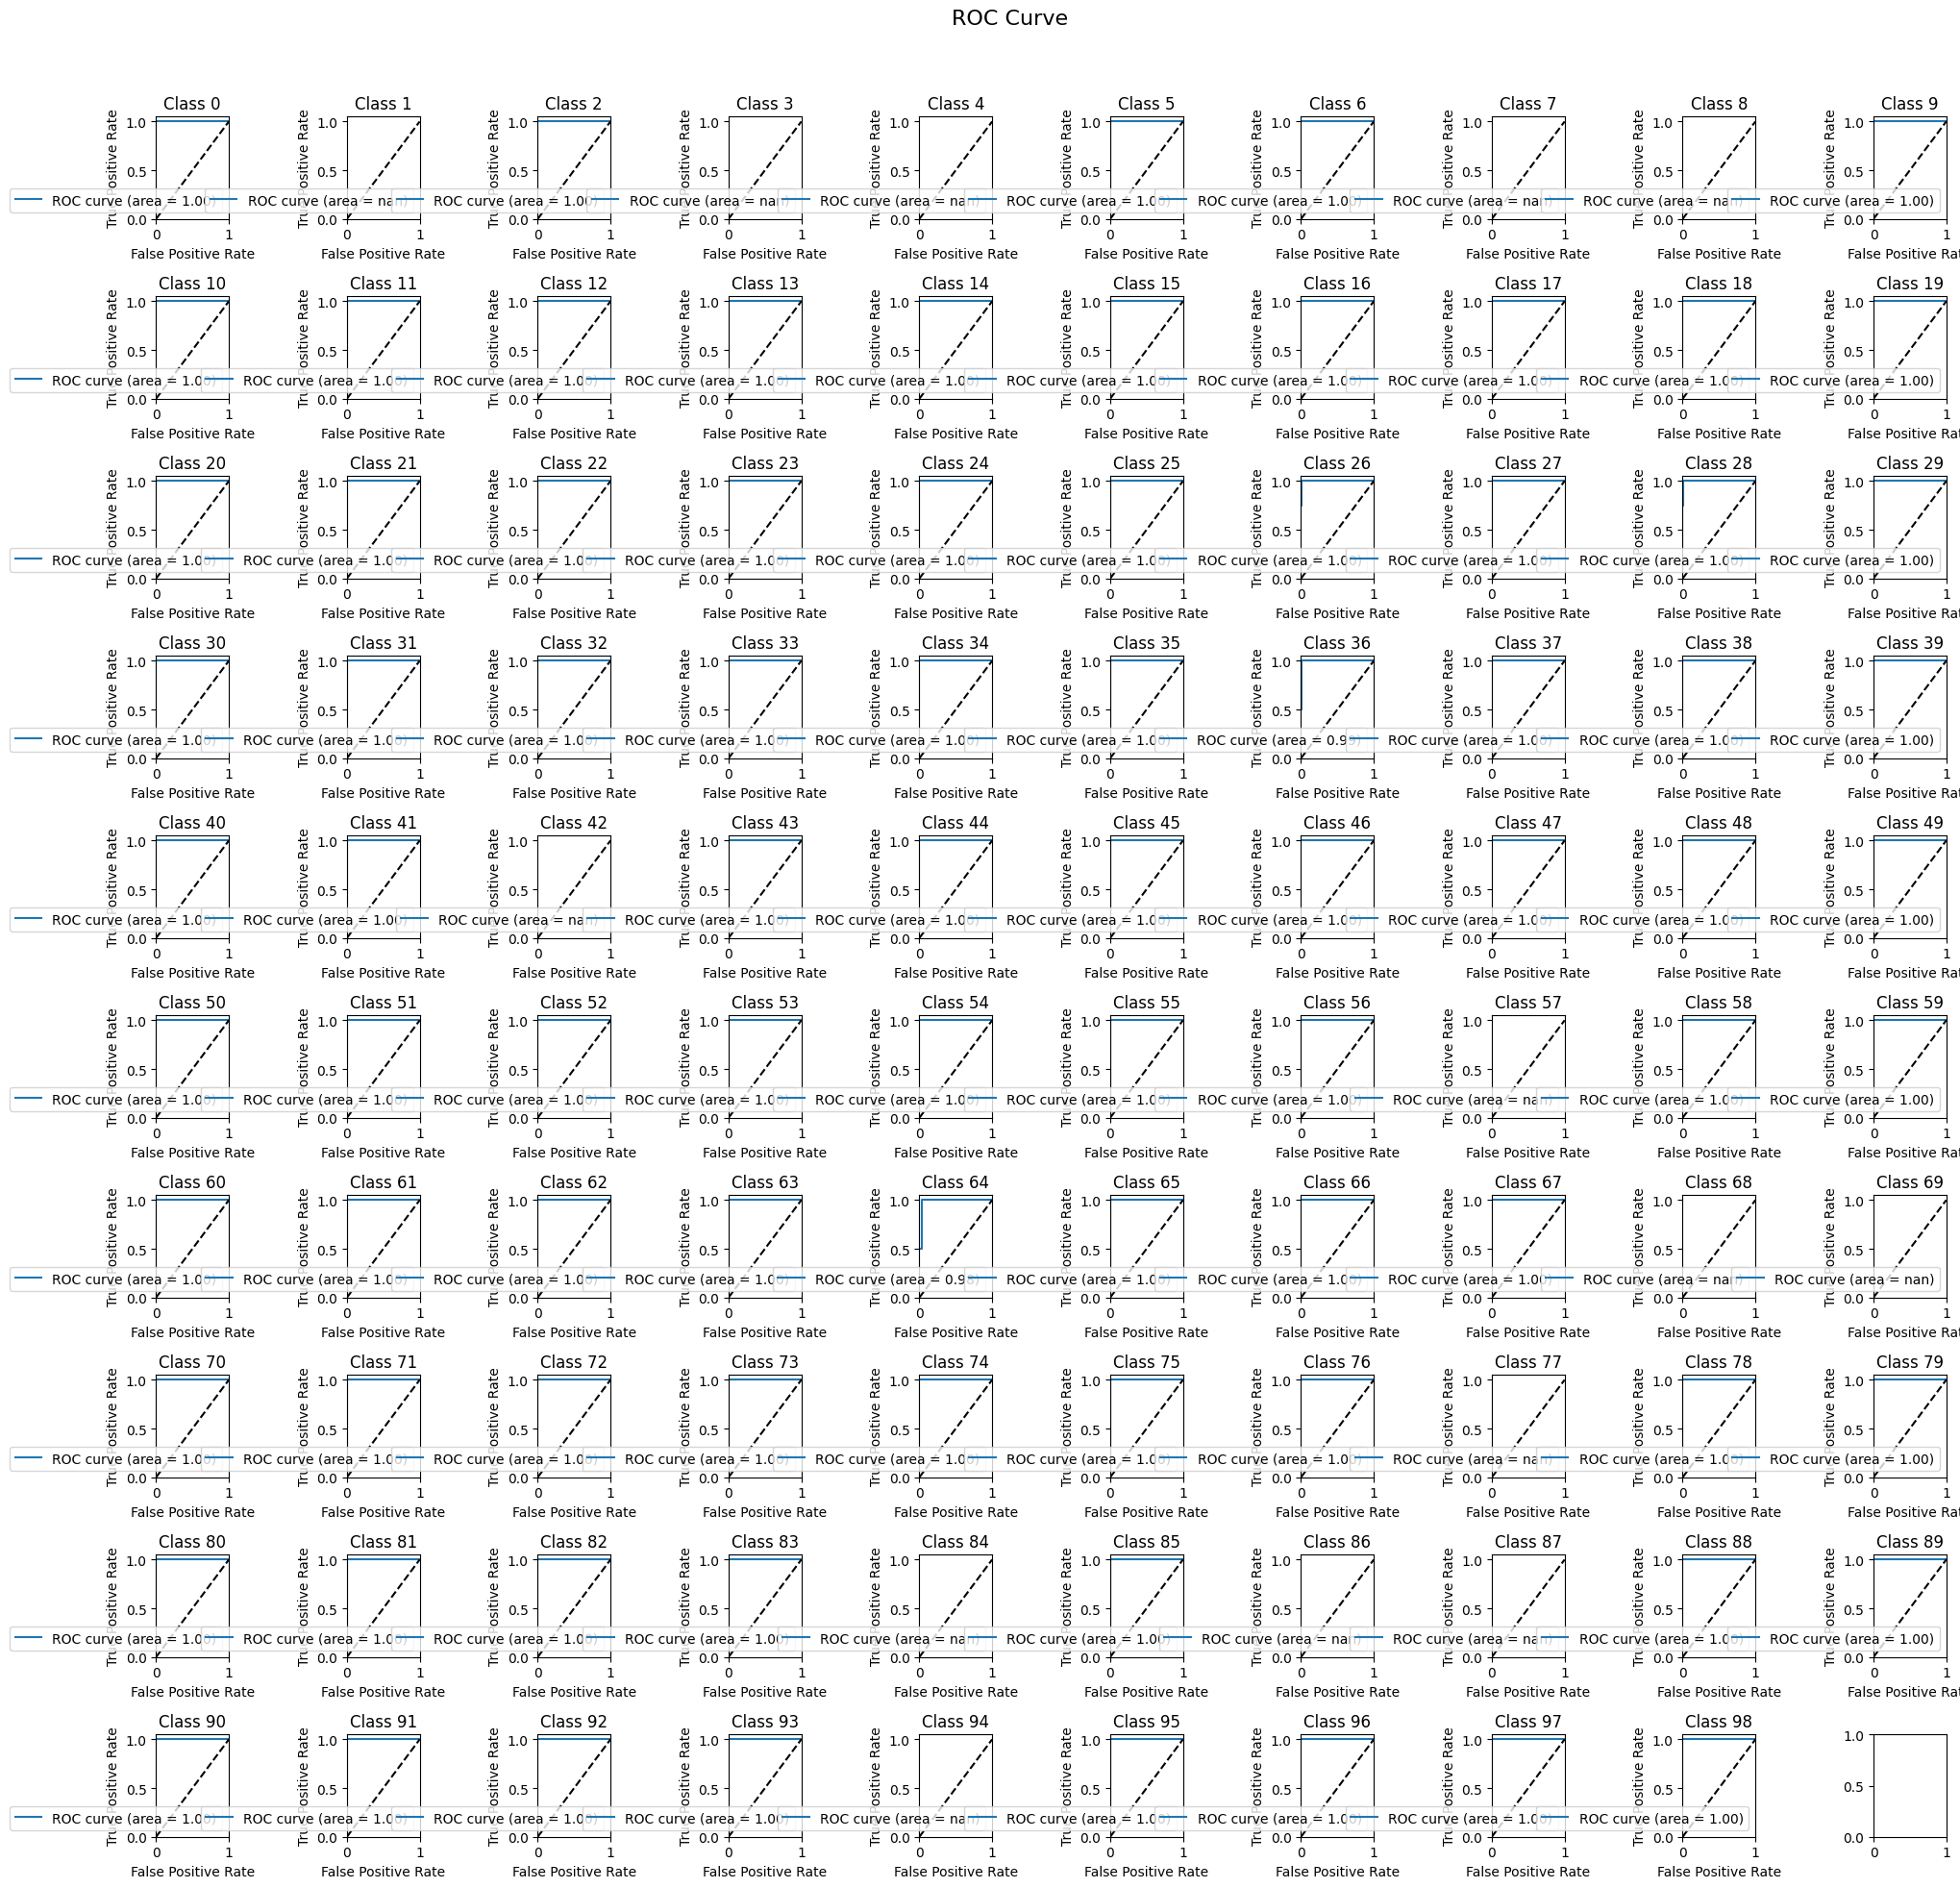

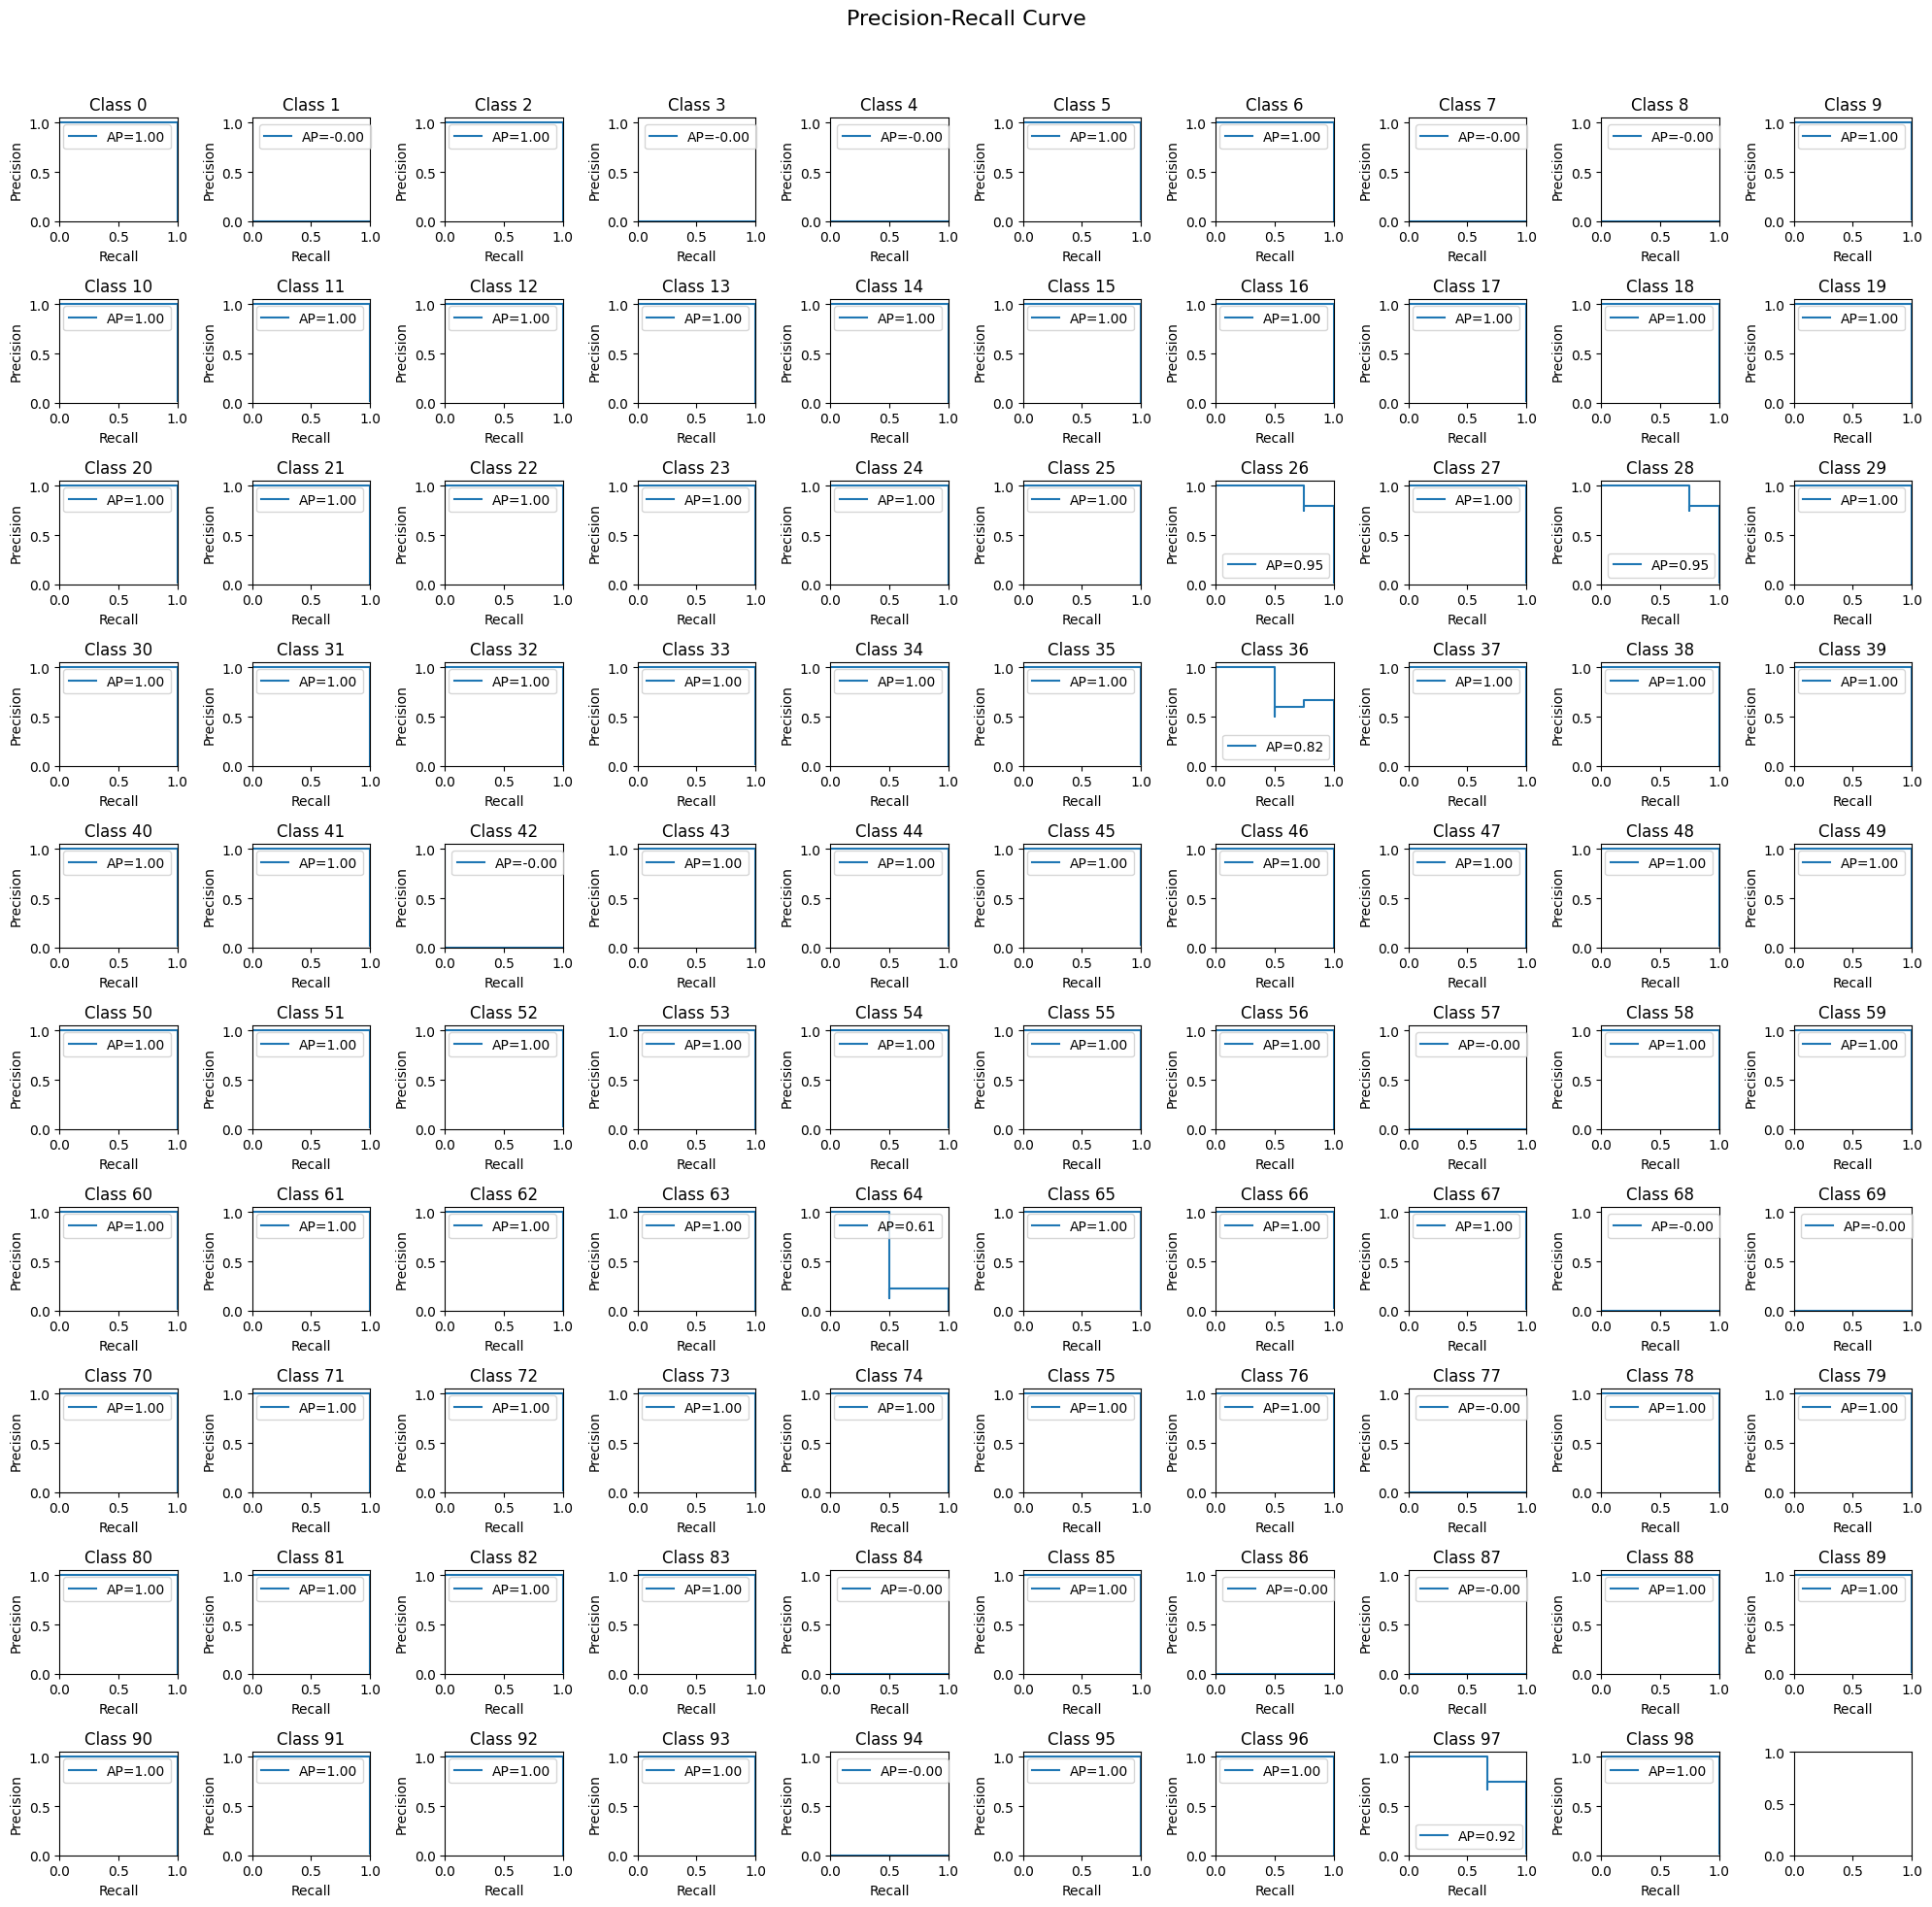

In [27]:
# Binarize the output. Replace 'y' with your validation labels e.g., 'y_val'
y_bin = label_binarize(y_val, classes=list(range(99)))

# Get the predicted probabilities from the best model
y_score = best_model.predict(X_val_reshaped)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Determine grid size for the plots
grid_size = int(np.ceil(np.sqrt(num_classes)))

# Set up figure for ROC plot
fig, axs = plt.subplots(grid_size, grid_size, figsize=(2*grid_size, 2*grid_size))
fig.suptitle('ROC Curve', fontsize=16)
for i, ax in enumerate(fig.axes):
    if i < num_classes:
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Class '+str(i))
        ax.legend(loc="lower right")

plt.tight_layout(rect=[0, 0, 1, 0.96]) # rect parameter ensures the suptitle does not overlap
plt.show()

# Compute Precision-Recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])

# Set up figure for Precision-Recall plot
fig, axs = plt.subplots(grid_size, grid_size, figsize=(2*grid_size, 2*grid_size))
fig.suptitle('Precision-Recall Curve', fontsize=16)
for i, ax in enumerate(fig.axes):
    if i < num_classes:
        ax.step(recall[i], precision[i], where='post', label='AP={0:0.2f}'.format(average_precision[i]))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.0])
        ax.set_title('Class '+str(i))
        ax.legend(loc="best")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

##### Generating output file

In [28]:
# Use the best_model to make predictions using the test_data for up-loading on Kaggle

# Load the test data
test_df = pd.read_csv('./input/test.csv.zip')

# Copy the original Test DataFrame
processed_test_df = test_df.copy()

# Initialize the scaler
scaler = MinMaxScaler()

# Your code seems to suggest that the 'id' column is not a feature for model training.
# Scale numeric columns
numeric_cols = processed_test_df.columns.drop(['id'])
processed_test_df[numeric_cols] = scaler.fit_transform(processed_test_df[numeric_cols])

# Define the reshape function for cnn
def reshape_for_cnn(X, n_channels):
    # Calculate the dimension of the square
    dim = int(np.sqrt(X.shape[1] // n_channels))

    # Reshape the data to (n_samples, dim, dim, n_channels) - suitable for CNN
    X_reshaped = X.values.reshape(-1, dim, dim, n_channels)
    return X_reshaped

# Reshape data for CNN
n_channels = 3 # set the number of channels according to the shape of your data

X_test = processed_test_df.drop(columns=['id'])
X_test_reshaped = reshape_for_cnn(X_test, n_channels)

# Predict the probabilities using the best model from above
test_predictions = best_model.predict(X_test_reshaped)
test_predictions = pd.DataFrame(test_predictions, columns=classes)

# Create submission DataFrame
submission_df = pd.DataFrame({'Id': test_df['id']}).join(test_predictions)

# Save DataFrame to csv
submission_df.to_csv('kaggle_submission_model1.csv', index=False)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


#### Model 2 : Intermediate CNN Model with 2-3 Convolutional Layers
A moderately complex model featuring 2-3 convolutional layers, 1-2 pooling layers, and 2 fully connected layers, balancing performance and complexity.

In [30]:
class IntermediateCNN:
    def __init__(self, num_class):
        self.num_class = num_class

    def build(self, hp: HyperParameters):
        model = Sequential()
        model.add(Conv2D(
            filters=hp.Choice('conv_filters_1', values=[64, 128]),
            kernel_size=(3, 3),
            padding='same',
            activation='relu',
            input_shape=(8, 8, 3)
        ))
        model.add(Conv2D(
            filters=hp.Choice('conv_filters_2', values=[64, 128]),
            kernel_size=(3, 3),
            padding='same',
            activation='relu'
        ))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(hp.Choice('dense_units', values=[128, 256]), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(0.5))
        model.add(Dense(self.num_class, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        return model

hypermodel = IntermediateCNN(num_class=num_classes)

# Cross Validation Approach
'''Utilizing a RandomSearch tuner to identify the optimal hyperparameters for a model,
as opposed to manually selecting hyperparameters for testing a few models, presents a more efficient
and effective method. This approach systematically explores a wide range of hyperparameter combinations
across 20 trials, each with 5 executions to ensure reliability in finding the best set.
By automating the search, it significantly increases the likelihood of discovering an optimal
configuration that might not be evident through manual selection. This method leverages computational
power to evaluate numerous possibilities in a structured manner, thereby reducing human bias and oversight.
It leads to potentially higher model accuracy and performance by rigorously testing a broad spectrum
of configurations, ensuring that the final model, trained with the best hyperparameters, is highly tuned
to the specific characteristics of the dataset.'''

# Searching for the best hyperparameters
tuner = RandomSearch(
    hypermodel.build,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=5,
    directory='random_search',
    project_name='leaf_classification'
)
tuner.search(
    x=X_train_reshaped,
    y=to_categorical(y_train, num_classes=num_classes),
    epochs=10,
    validation_split=0.2
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train_reshaped,
    to_categorical(y_train, num_classes=num_classes),
    epochs=10,
    validation_data=(X_val_reshaped, to_categorical(y_val, num_classes=num_classes))
)

Trial 8 Complete [00h 01m 08s]
val_accuracy: 0.9220125794410705

Best val_accuracy So Far: 0.9220125794410705
Total elapsed time: 00h 07m 27s
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - accuracy: 0.0355 - loss: 4.9789 - val_accuracy: 0.0758 - val_loss: 4.6781
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1109 - loss: 4.4082 - val_accuracy: 0.1919 - val_loss: 3.8466
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2306 - loss: 3.4866 - val_accuracy: 0.5606 - val_loss: 2.4029
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4462 - loss: 2.4389 - val_accuracy: 0.7576 - val_loss: 1.4758
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6112 - loss: 1.6968 - val_accuracy: 0.8990 - val_loss: 0.9765
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7359 - loss: 1.2617 - val_accuracy: 0.9141 - val_loss: 0.7879
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7708 - loss: 1.2116 - val_accuracy:

In [32]:
test_loss, test_acc = best_model.evaluate(X_val_reshaped, to_categorical(y_val, num_classes=num_classes))
print(f"Validation accuracy: {test_acc*100:.2f}%")
print(f"Validation loss: {test_loss:.4f}")


model_config = best_model.get_config()

model_layers = model_config['layers']

# Convolutional layer
conv_layer_config = next(layer for layer in model_layers if layer['class_name'] == 'Conv2D')
conv_filters = conv_layer_config['config'].get('filters')

# Dense layers
dense_layers_config = [layer for layer in model_layers if layer['class_name'] == 'Dense']
dense_units = [config['config'].get('units') for config in dense_layers_config]

# Dropout layer
dropout_layer_config = next(layer for layer in model_layers if layer['class_name'] == 'Dropout')
dropout_rate = dropout_layer_config['config'].get('rate')

# L2 Regularization
l2_regularization = None  # Initialize to None
for config in dense_layers_config:
    kernel_regularizer = config['config'].get('kernel_regularizer')
    if kernel_regularizer is not None:
        # Extract the 'l2' regularization value directly from the dictionary
        l2_regularization = kernel_regularizer.get('l2')
        break  # Break once we find the first regularizer

l2_regularization = l2_reg_config['l2'] if l2_reg_config else None
# l2_reg_config = next(config['config'].get('kernel_regularizer', {}) for config in dense_layers_config if config['config'].get('kernel_regularizer'))
# l2_regularization = l2_reg_config.get('l2') if l2_reg_config else None

# These are some of the most important hyperparameters in this model.
print(f"Conv2D filters: {conv_filters}")
print(f"Dense units: {dense_units}")
print(f"Dropout rate: {dropout_rate}")
print(f"L2 regularization: {l2_regularization}")

# Printing the learning_rate
optimizer_config = best_model.optimizer.get_config()
learning_rate = optimizer_config.get('learning_rate')

print("The learning rate for the best model is:", learning_rate)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9621 - loss: 0.5635 
Validation accuracy: 95.96%
Validation loss: 0.5704
Conv2D filters: 64
Dense units: [256, 99]
Dropout rate: 0.5
L2 regularization: None
The learning rate for the best model is: 0.0010000000474974513


##### Plotting the Multi-Class ROC and Precision / Recall Graphs

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


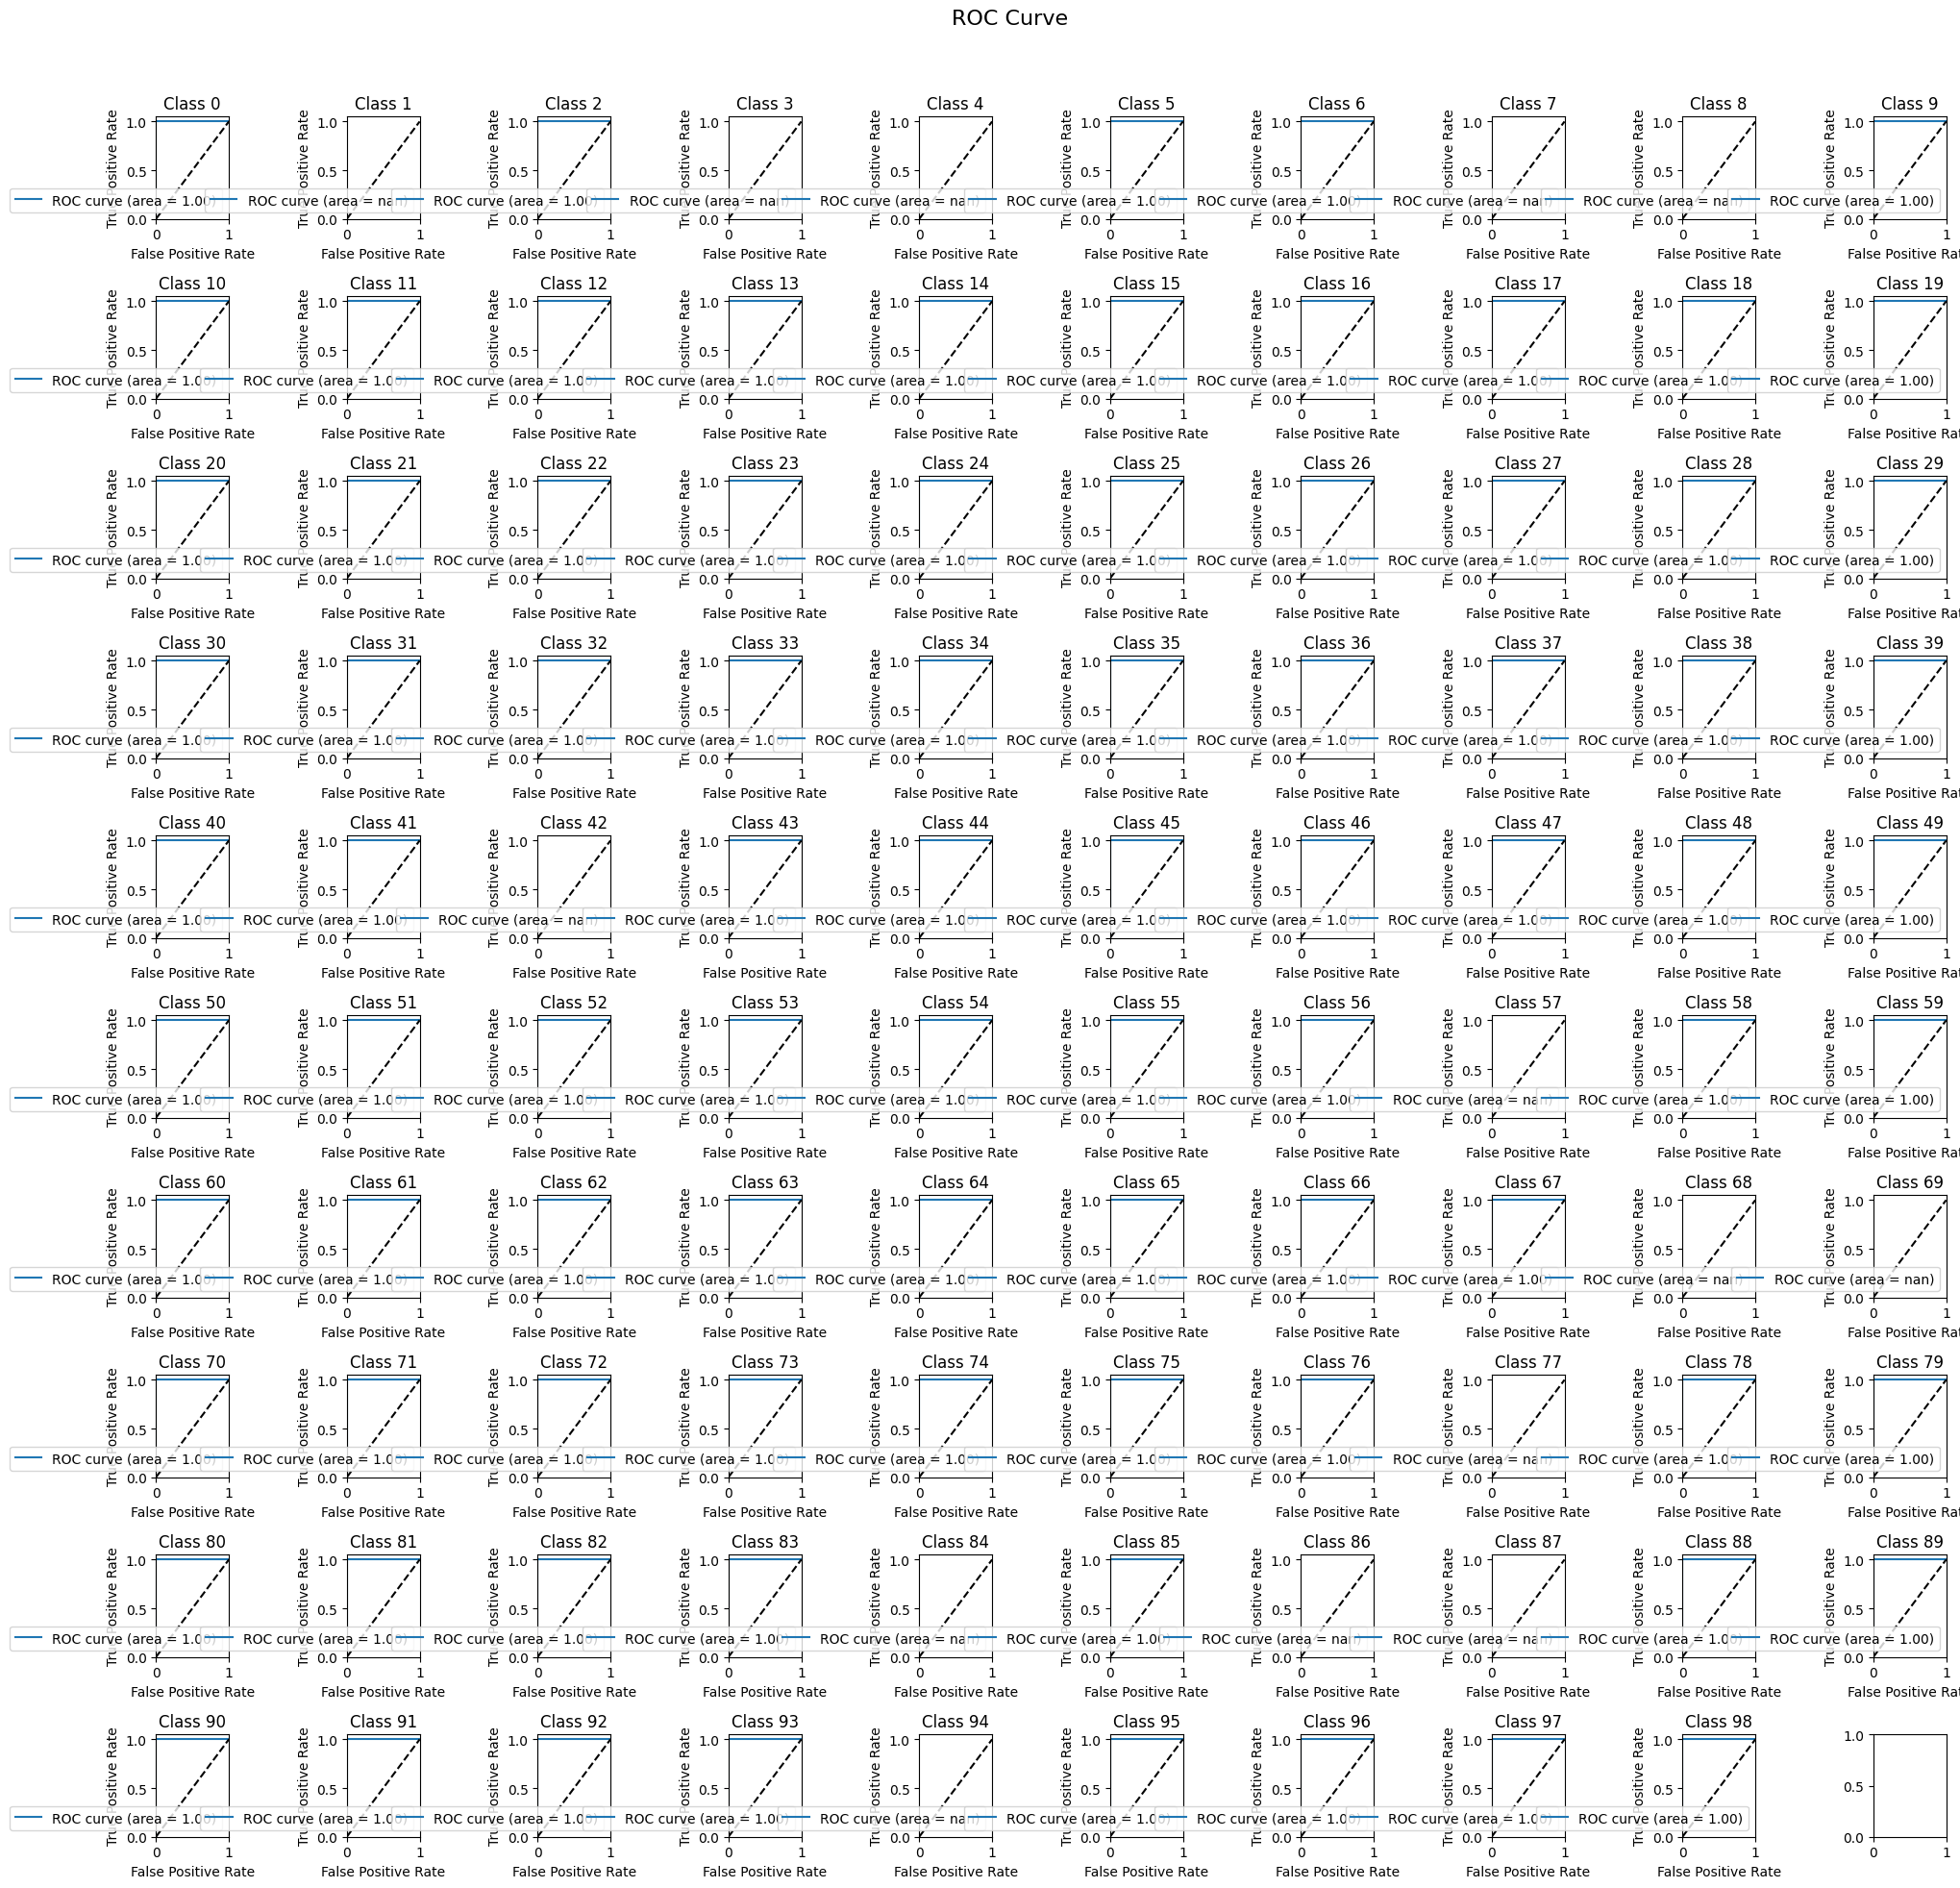

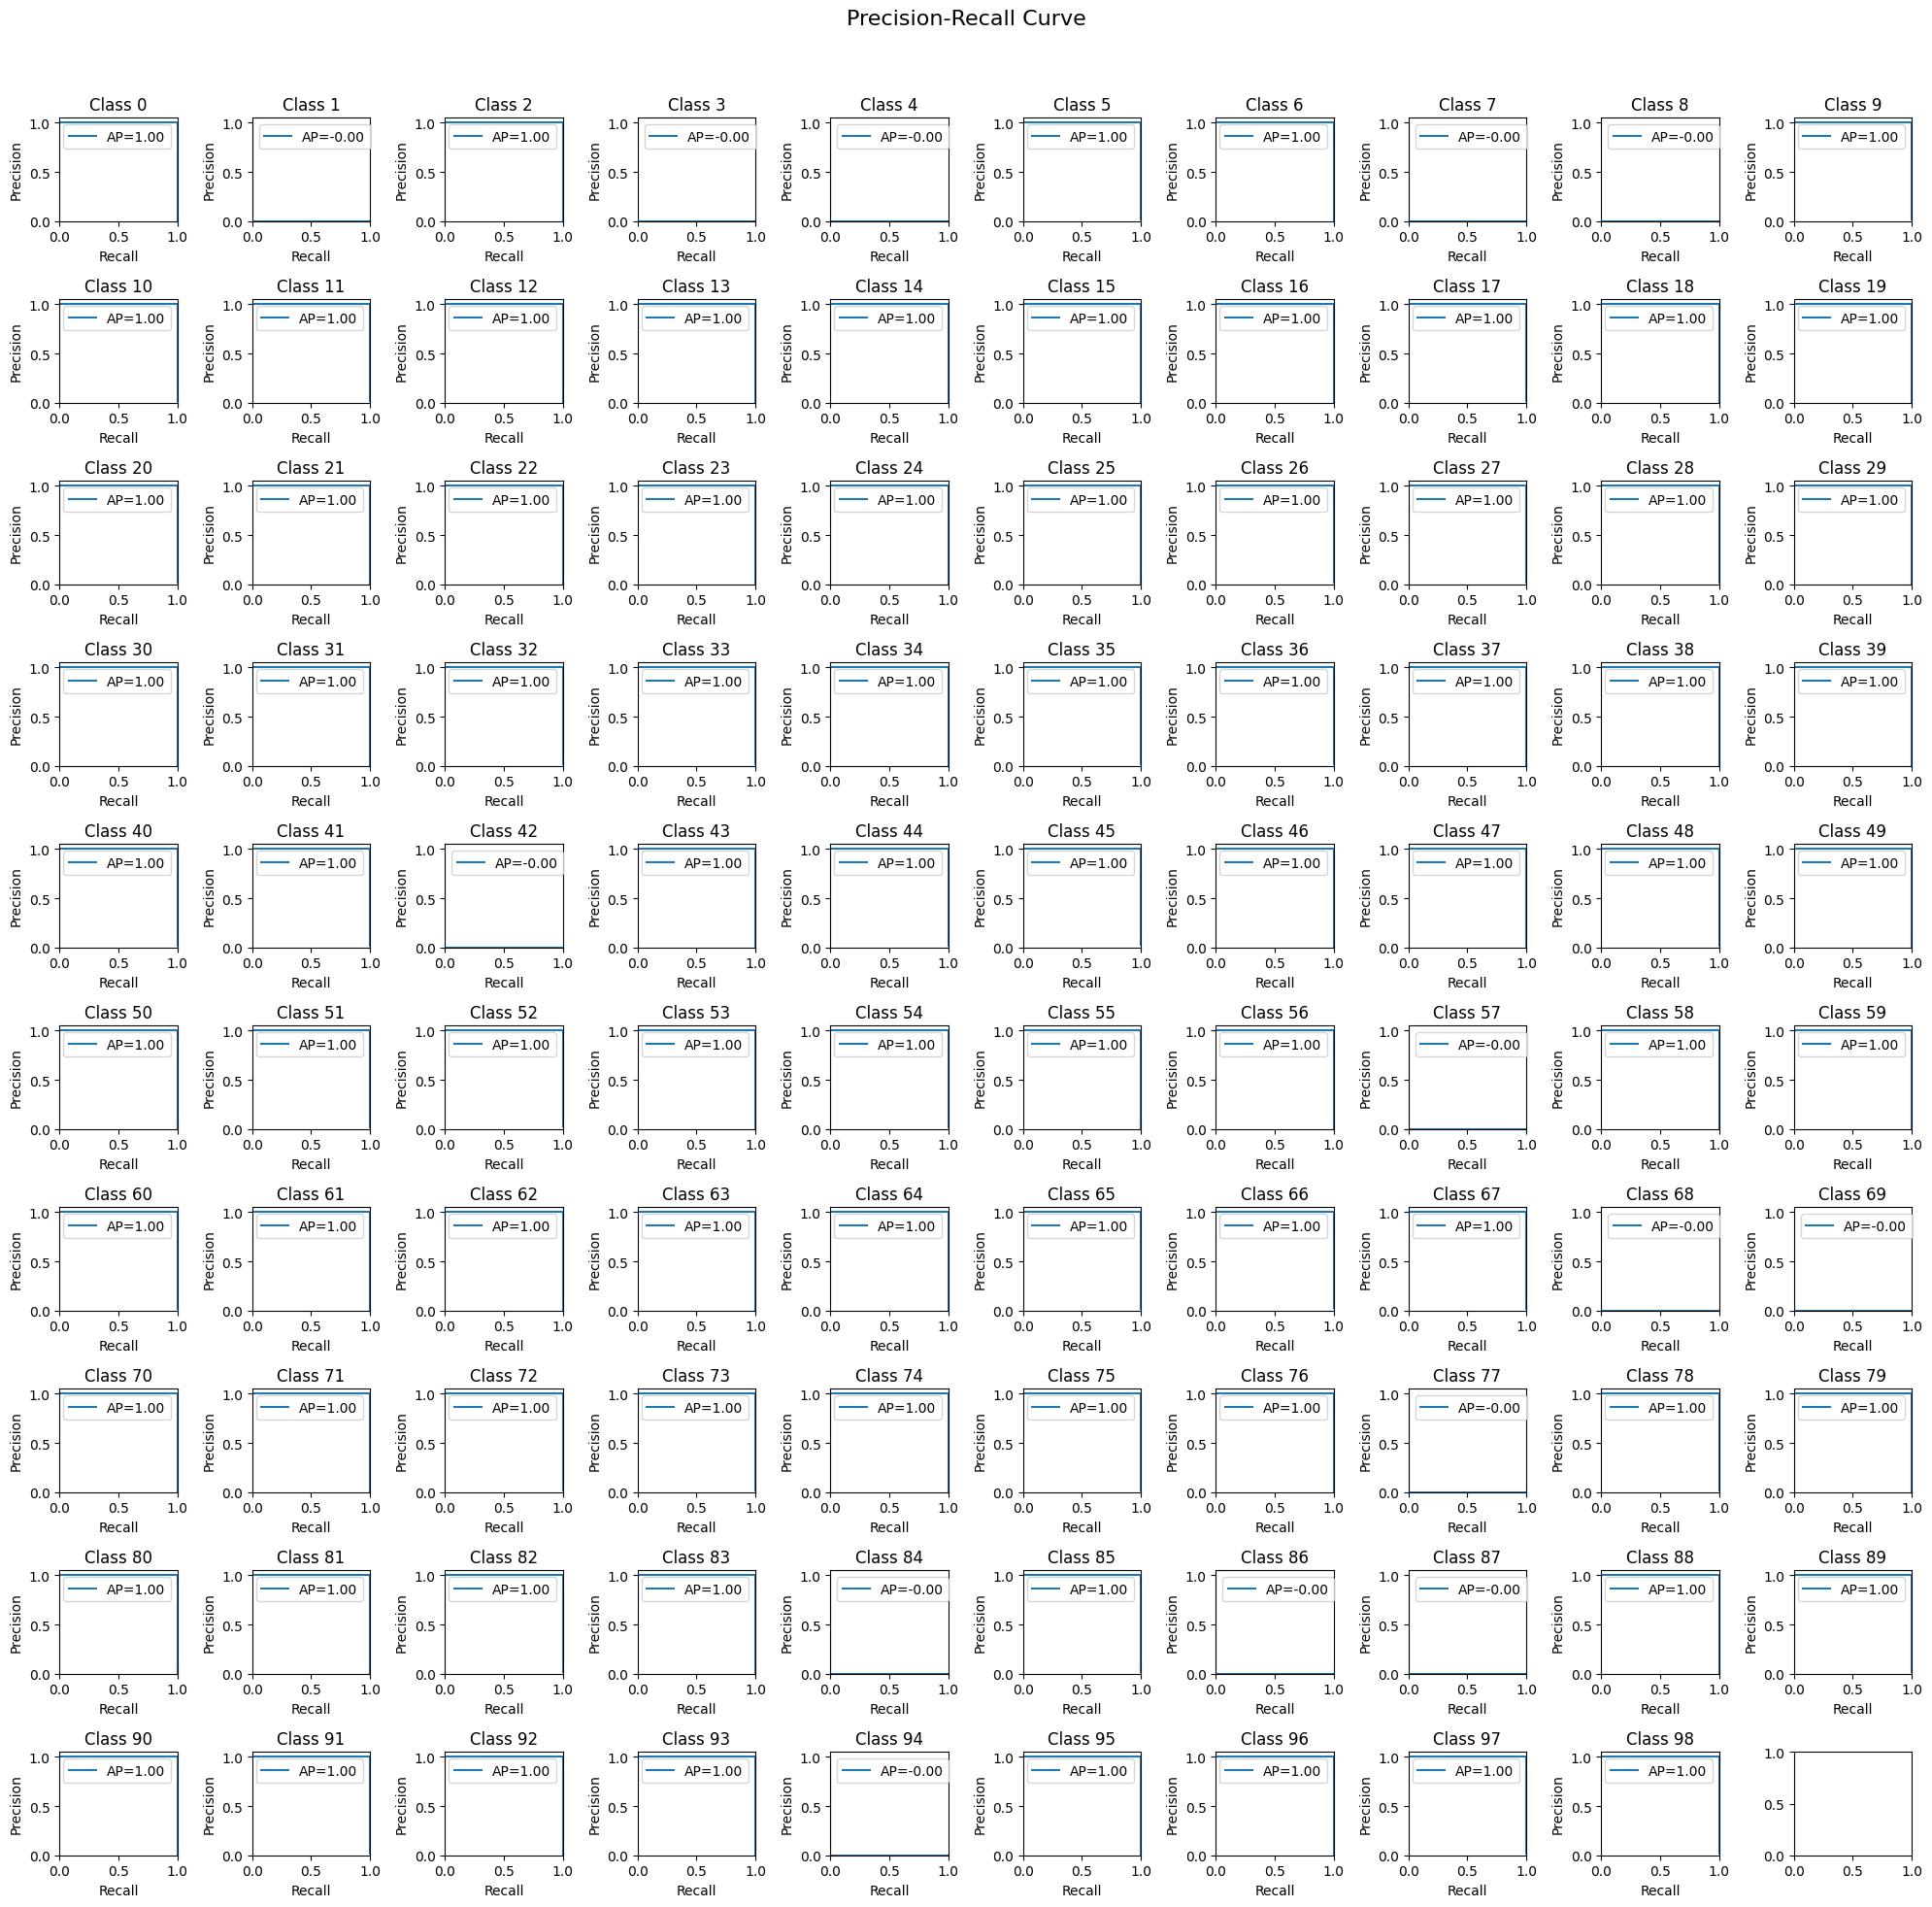

In [33]:
# Binarize the output. Replace 'y' with your validation labels e.g., 'y_val'
y_bin = label_binarize(y_val, classes=list(range(99)))

# Get the predicted probabilities from the best model
y_score = best_model.predict(X_val_reshaped)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Determine grid size for the plots
grid_size = int(np.ceil(np.sqrt(num_classes)))

# Set up figure for ROC plot
fig, axs = plt.subplots(grid_size, grid_size, figsize=(2*grid_size, 2*grid_size))
fig.suptitle('ROC Curve', fontsize=16)
for i, ax in enumerate(fig.axes):
    if i < num_classes:
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Class '+str(i))
        ax.legend(loc="lower right")

plt.tight_layout(rect=[0, 0, 1, 0.96]) # rect parameter ensures the suptitle does not overlap
plt.show()

# Compute Precision-Recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])

# Set up figure for Precision-Recall plot
fig, axs = plt.subplots(grid_size, grid_size, figsize=(2*grid_size, 2*grid_size))
fig.suptitle('Precision-Recall Curve', fontsize=16)
for i, ax in enumerate(fig.axes):
    if i < num_classes:
        ax.step(recall[i], precision[i], where='post', label='AP={0:0.2f}'.format(average_precision[i]))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.0])
        ax.set_title('Class '+str(i))
        ax.legend(loc="best")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

##### Generating output file

In [34]:
# Use the best_model to make predictions using the test_data for up-loading on Kaggle

# Load the test data
test_df = pd.read_csv('./input/test.csv.zip')

# Copy the original Test DataFrame
processed_test_df = test_df.copy()

# Initialize the scaler
scaler = MinMaxScaler()

# Your code seems to suggest that the 'id' column is not a feature for model training.
# Scale numeric columns
numeric_cols = processed_test_df.columns.drop(['id'])
processed_test_df[numeric_cols] = scaler.fit_transform(processed_test_df[numeric_cols])

# Define the reshape function for cnn
def reshape_for_cnn(X, n_channels):
    # Calculate the dimension of the square
    dim = int(np.sqrt(X.shape[1] // n_channels))

    # Reshape the data to (n_samples, dim, dim, n_channels) - suitable for CNN
    X_reshaped = X.values.reshape(-1, dim, dim, n_channels)
    return X_reshaped

# Reshape data for CNN
n_channels = 3 # set the number of channels according to the shape of your data

X_test = processed_test_df.drop(columns=['id'])
X_test_reshaped = reshape_for_cnn(X_test, n_channels)

# Predict the probabilities using the best model from above
test_predictions = best_model.predict(X_test_reshaped)
test_predictions = pd.DataFrame(test_predictions, columns=classes)

# Create submission DataFrame
submission_df = pd.DataFrame({'Id': test_df['id']}).join(test_predictions)

# Save DataFrame to csv
submission_df.to_csv('kaggle_submission_model2.csv', index=False)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


#### Model 3 : Complex CNN Model with 3-4 Convolutional Layers
An advanced model with 3-4 convolutional layers, 2-3 pooling layers, and 2-3 fully connected layers, incorporating multiple regularization techniques for enhanced accuracy.

In [36]:
class ComplexCNN:
    def __init__(self, num_class):
        self.num_class = num_class

    def build(self, hp: HyperParameters):
        model = Sequential()
        model.add(Conv2D(
            filters=hp.Choice('conv_filters_1', values=[128, 256]),
            kernel_size=(3, 3),
            padding='same',
            activation='relu',
            input_shape=(8, 8, 3)
        ))
        model.add(Conv2D(
            filters=hp.Choice('conv_filters_2', values=[128, 256]),
            kernel_size=(3, 3),
            padding='same',
            activation='relu'
        ))
        model.add(Conv2D(
            filters=hp.Choice('conv_filters_3', values=[128, 256]),
            kernel_size=(3, 3),
            padding='same',
            activation='relu'
        ))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(hp.Choice('dense_units', values=[256, 512]), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(0.5))
        model.add(Dense(self.num_class, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        return model

hypermodel = ComplexCNN(num_class=num_classes)

# Cross Validation Approach
'''Utilizing a RandomSearch tuner to identify the optimal hyperparameters for a model,
as opposed to manually selecting hyperparameters for testing a few models, presents a more efficient
and effective method. This approach systematically explores a wide range of hyperparameter combinations
across 20 trials, each with 5 executions to ensure reliability in finding the best set.
By automating the search, it significantly increases the likelihood of discovering an optimal
configuration that might not be evident through manual selection. This method leverages computational
power to evaluate numerous possibilities in a structured manner, thereby reducing human bias and oversight.
It leads to potentially higher model accuracy and performance by rigorously testing a broad spectrum
of configurations, ensuring that the final model, trained with the best hyperparameters, is highly tuned
to the specific characteristics of the dataset.'''

# Searching for the best hyperparameters
tuner = RandomSearch(
    hypermodel.build,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=5,
    directory='random_search',
    project_name='leaf_classification'
)
tuner.search(
    x=X_train_reshaped,
    y=to_categorical(y_train, num_classes=num_classes),
    epochs=10,
    validation_split=0.2
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train_reshaped,
    to_categorical(y_train, num_classes=num_classes),
    epochs=10,
    validation_data=(X_val_reshaped, to_categorical(y_val, num_classes=num_classes))
)

Trial 15 Complete [00h 01m 26s]
val_accuracy: 0.9031446576118469

Best val_accuracy So Far: 0.9283018827438354
Total elapsed time: 00h 20m 09s
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - accuracy: 0.0094 - loss: 5.2960 - val_accuracy: 0.0051 - val_loss: 4.8339
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0336 - loss: 4.7328 - val_accuracy: 0.0556 - val_loss: 4.4105
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1393 - loss: 3.9994 - val_accuracy: 0.3586 - val_loss: 2.8625
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4035 - loss: 2.5497 - val_accuracy: 0.7374 - val_loss: 1.5561
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6310 - loss: 1.6847 - val_accuracy: 0.8788 - val_loss: 0.9438
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7896 - loss: 1.1909 - val_accuracy: 0.9394 - val_loss: 0.7517
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8584 - loss: 1.0112 - val_accuracy:

In [38]:
test_loss, test_acc = best_model.evaluate(X_val_reshaped, to_categorical(y_val, num_classes=num_classes))
print(f"Validation accuracy: {test_acc*100:.2f}%")
print(f"Validation loss: {test_loss:.4f}")


model_config = best_model.get_config()

model_layers = model_config['layers']

# Convolutional layer
conv_layer_config = next(layer for layer in model_layers if layer['class_name'] == 'Conv2D')
conv_filters = conv_layer_config['config'].get('filters')

# Dense layers
dense_layers_config = [layer for layer in model_layers if layer['class_name'] == 'Dense']
dense_units = [config['config'].get('units') for config in dense_layers_config]

# Dropout layer
dropout_layer_config = next(layer for layer in model_layers if layer['class_name'] == 'Dropout')
dropout_rate = dropout_layer_config['config'].get('rate')

# L2 Regularization
l2_regularization = None  # Initialize to None
for config in dense_layers_config:
    kernel_regularizer = config['config'].get('kernel_regularizer')
    if kernel_regularizer is not None:
        # Extract the 'l2' regularization value directly from the dictionary
        l2_regularization = kernel_regularizer.get('l2')
        break  # Break once we find the first regularizer

l2_regularization = l2_reg_config['l2'] if l2_reg_config else None
# l2_reg_config = next(config['config'].get('kernel_regularizer', {}) for config in dense_layers_config if config['config'].get('kernel_regularizer'))
# l2_regularization = l2_reg_config.get('l2') if l2_reg_config else None

# These are some of the most important hyperparameters in this model.
print(f"Conv2D filters: {conv_filters}")
print(f"Dense units: {dense_units}")
print(f"Dropout rate: {dropout_rate}")
print(f"L2 regularization: {l2_regularization}")

# Printing the learning_rate
optimizer_config = best_model.optimizer.get_config()
learning_rate = optimizer_config.get('learning_rate')

print("The learning rate for the best model is:", learning_rate)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9623 - loss: 0.6934 
Validation accuracy: 96.46%
Validation loss: 0.7009
Conv2D filters: 128
Dense units: [512, 99]
Dropout rate: 0.5
L2 regularization: None
The learning rate for the best model is: 0.0010000000474974513


##### Plotting the Multi-Class ROC and Precision / Recall Graphs

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


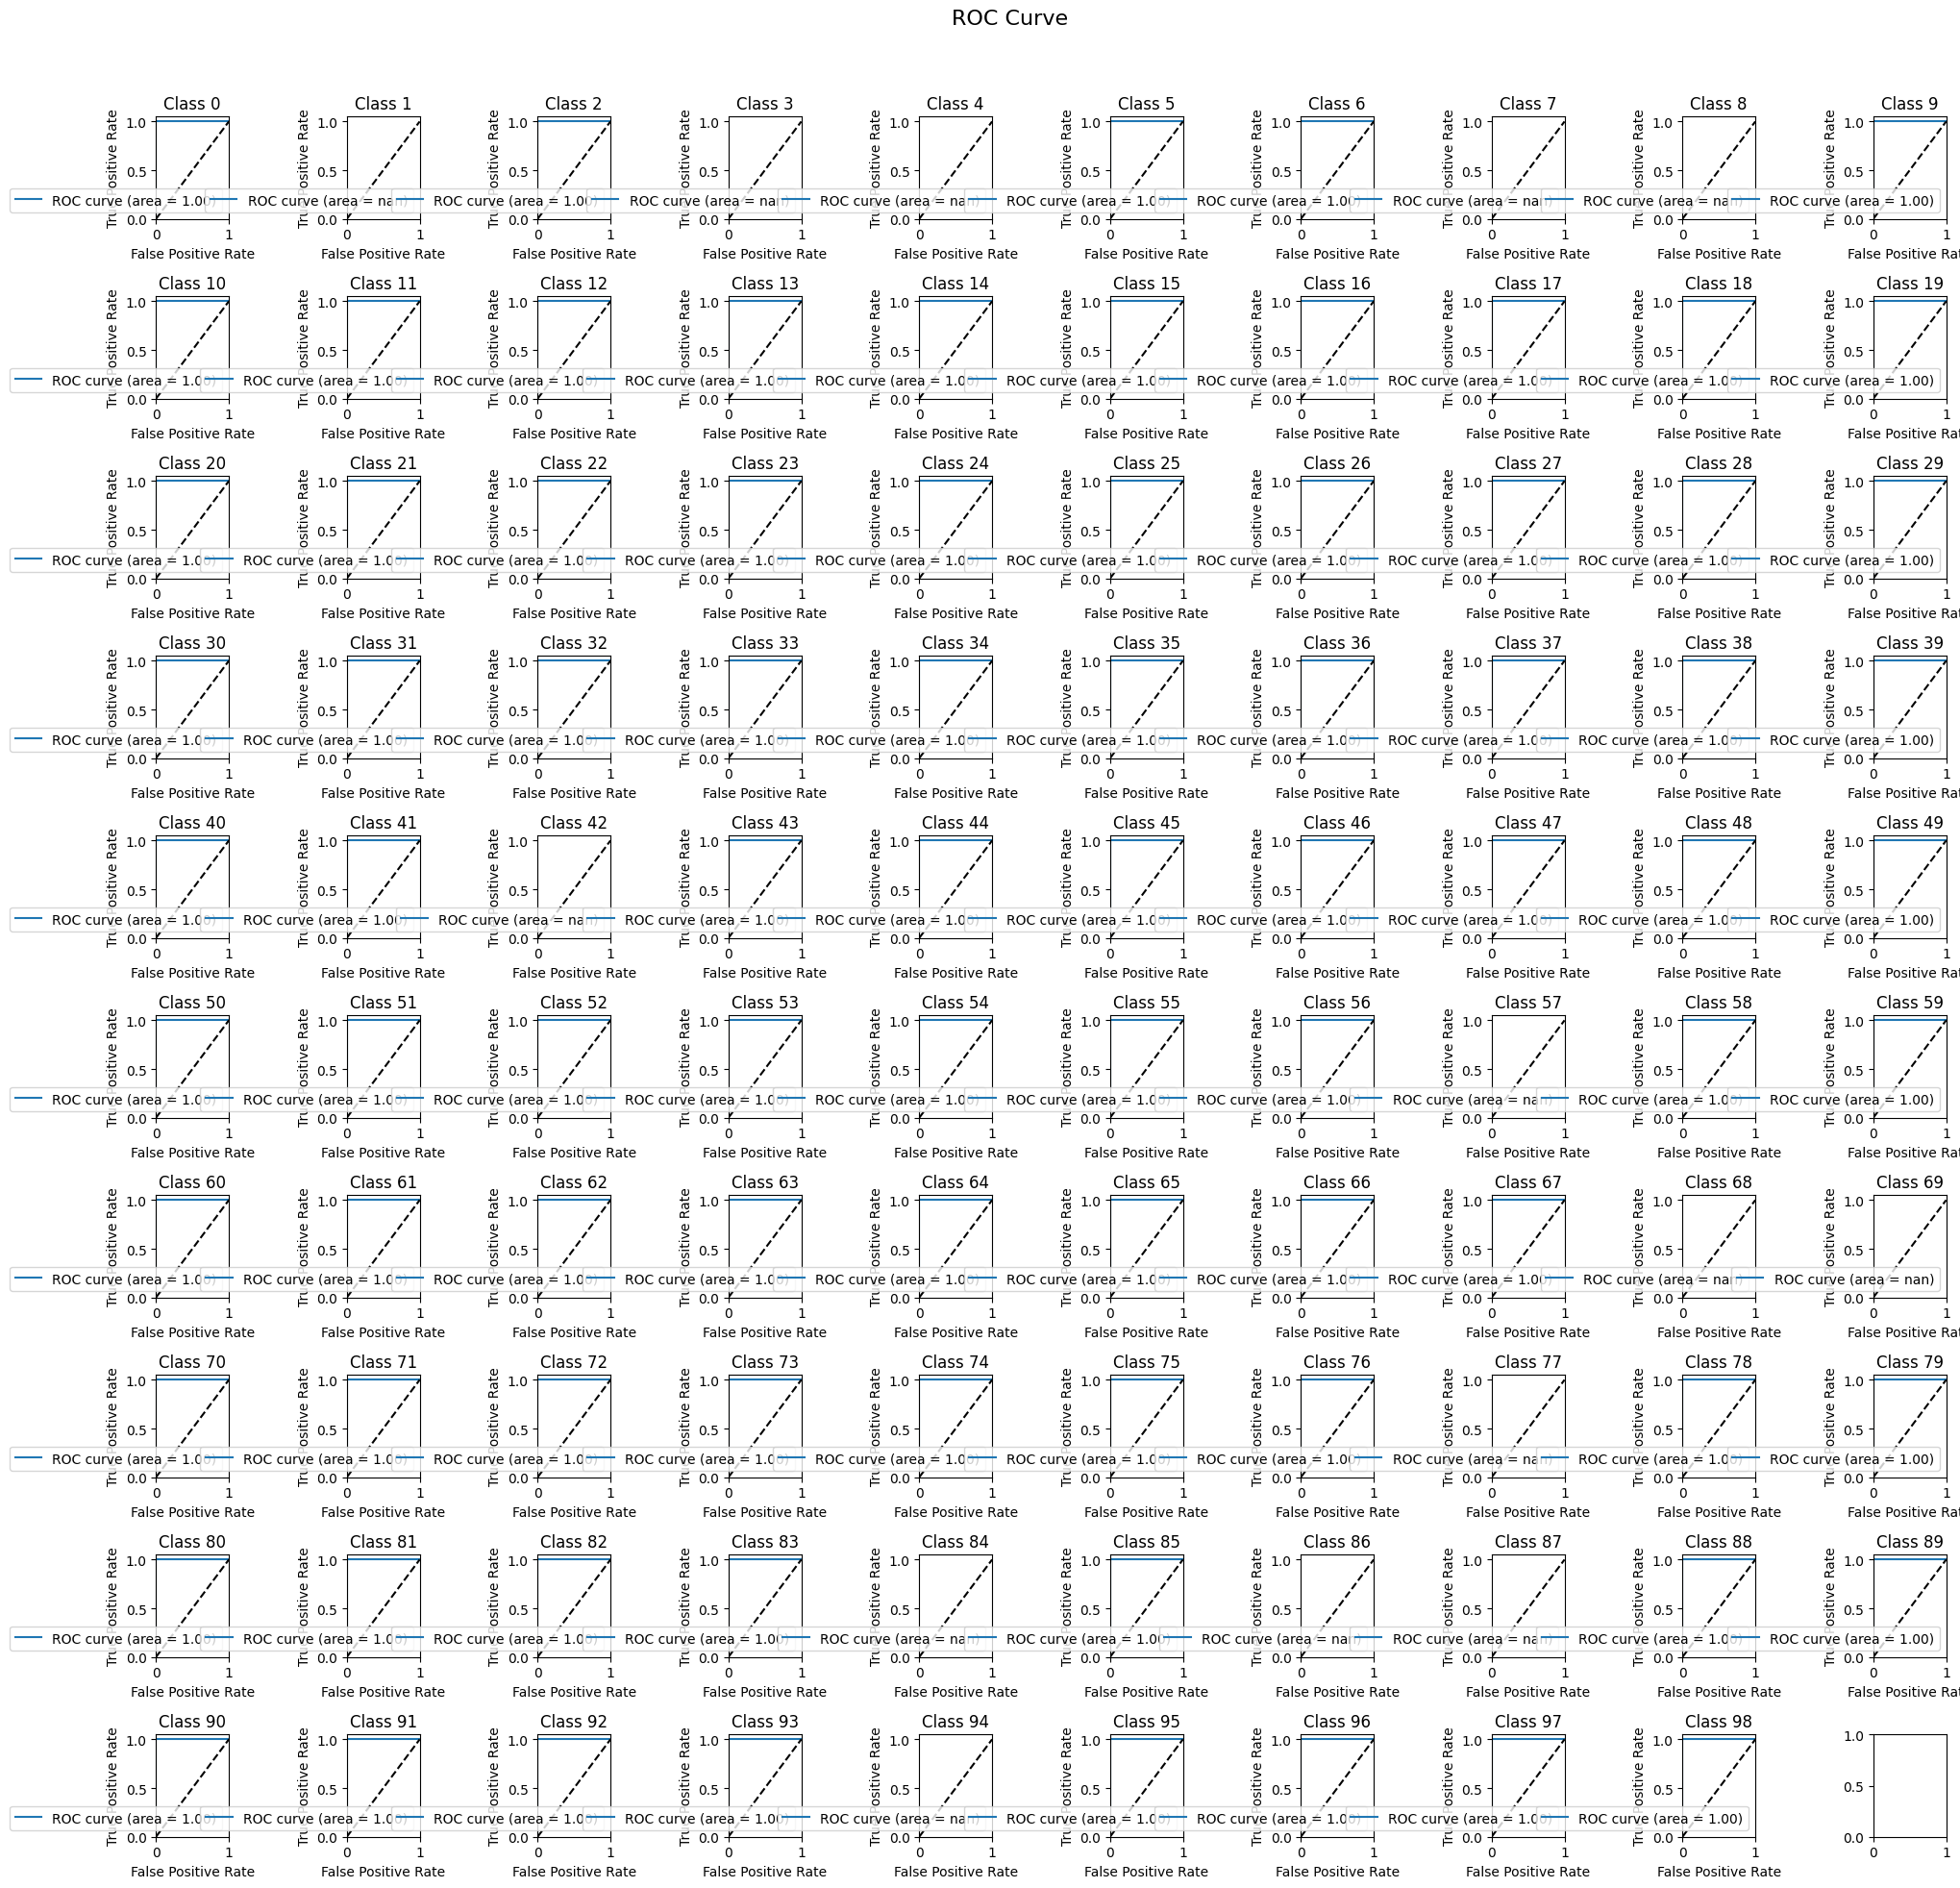

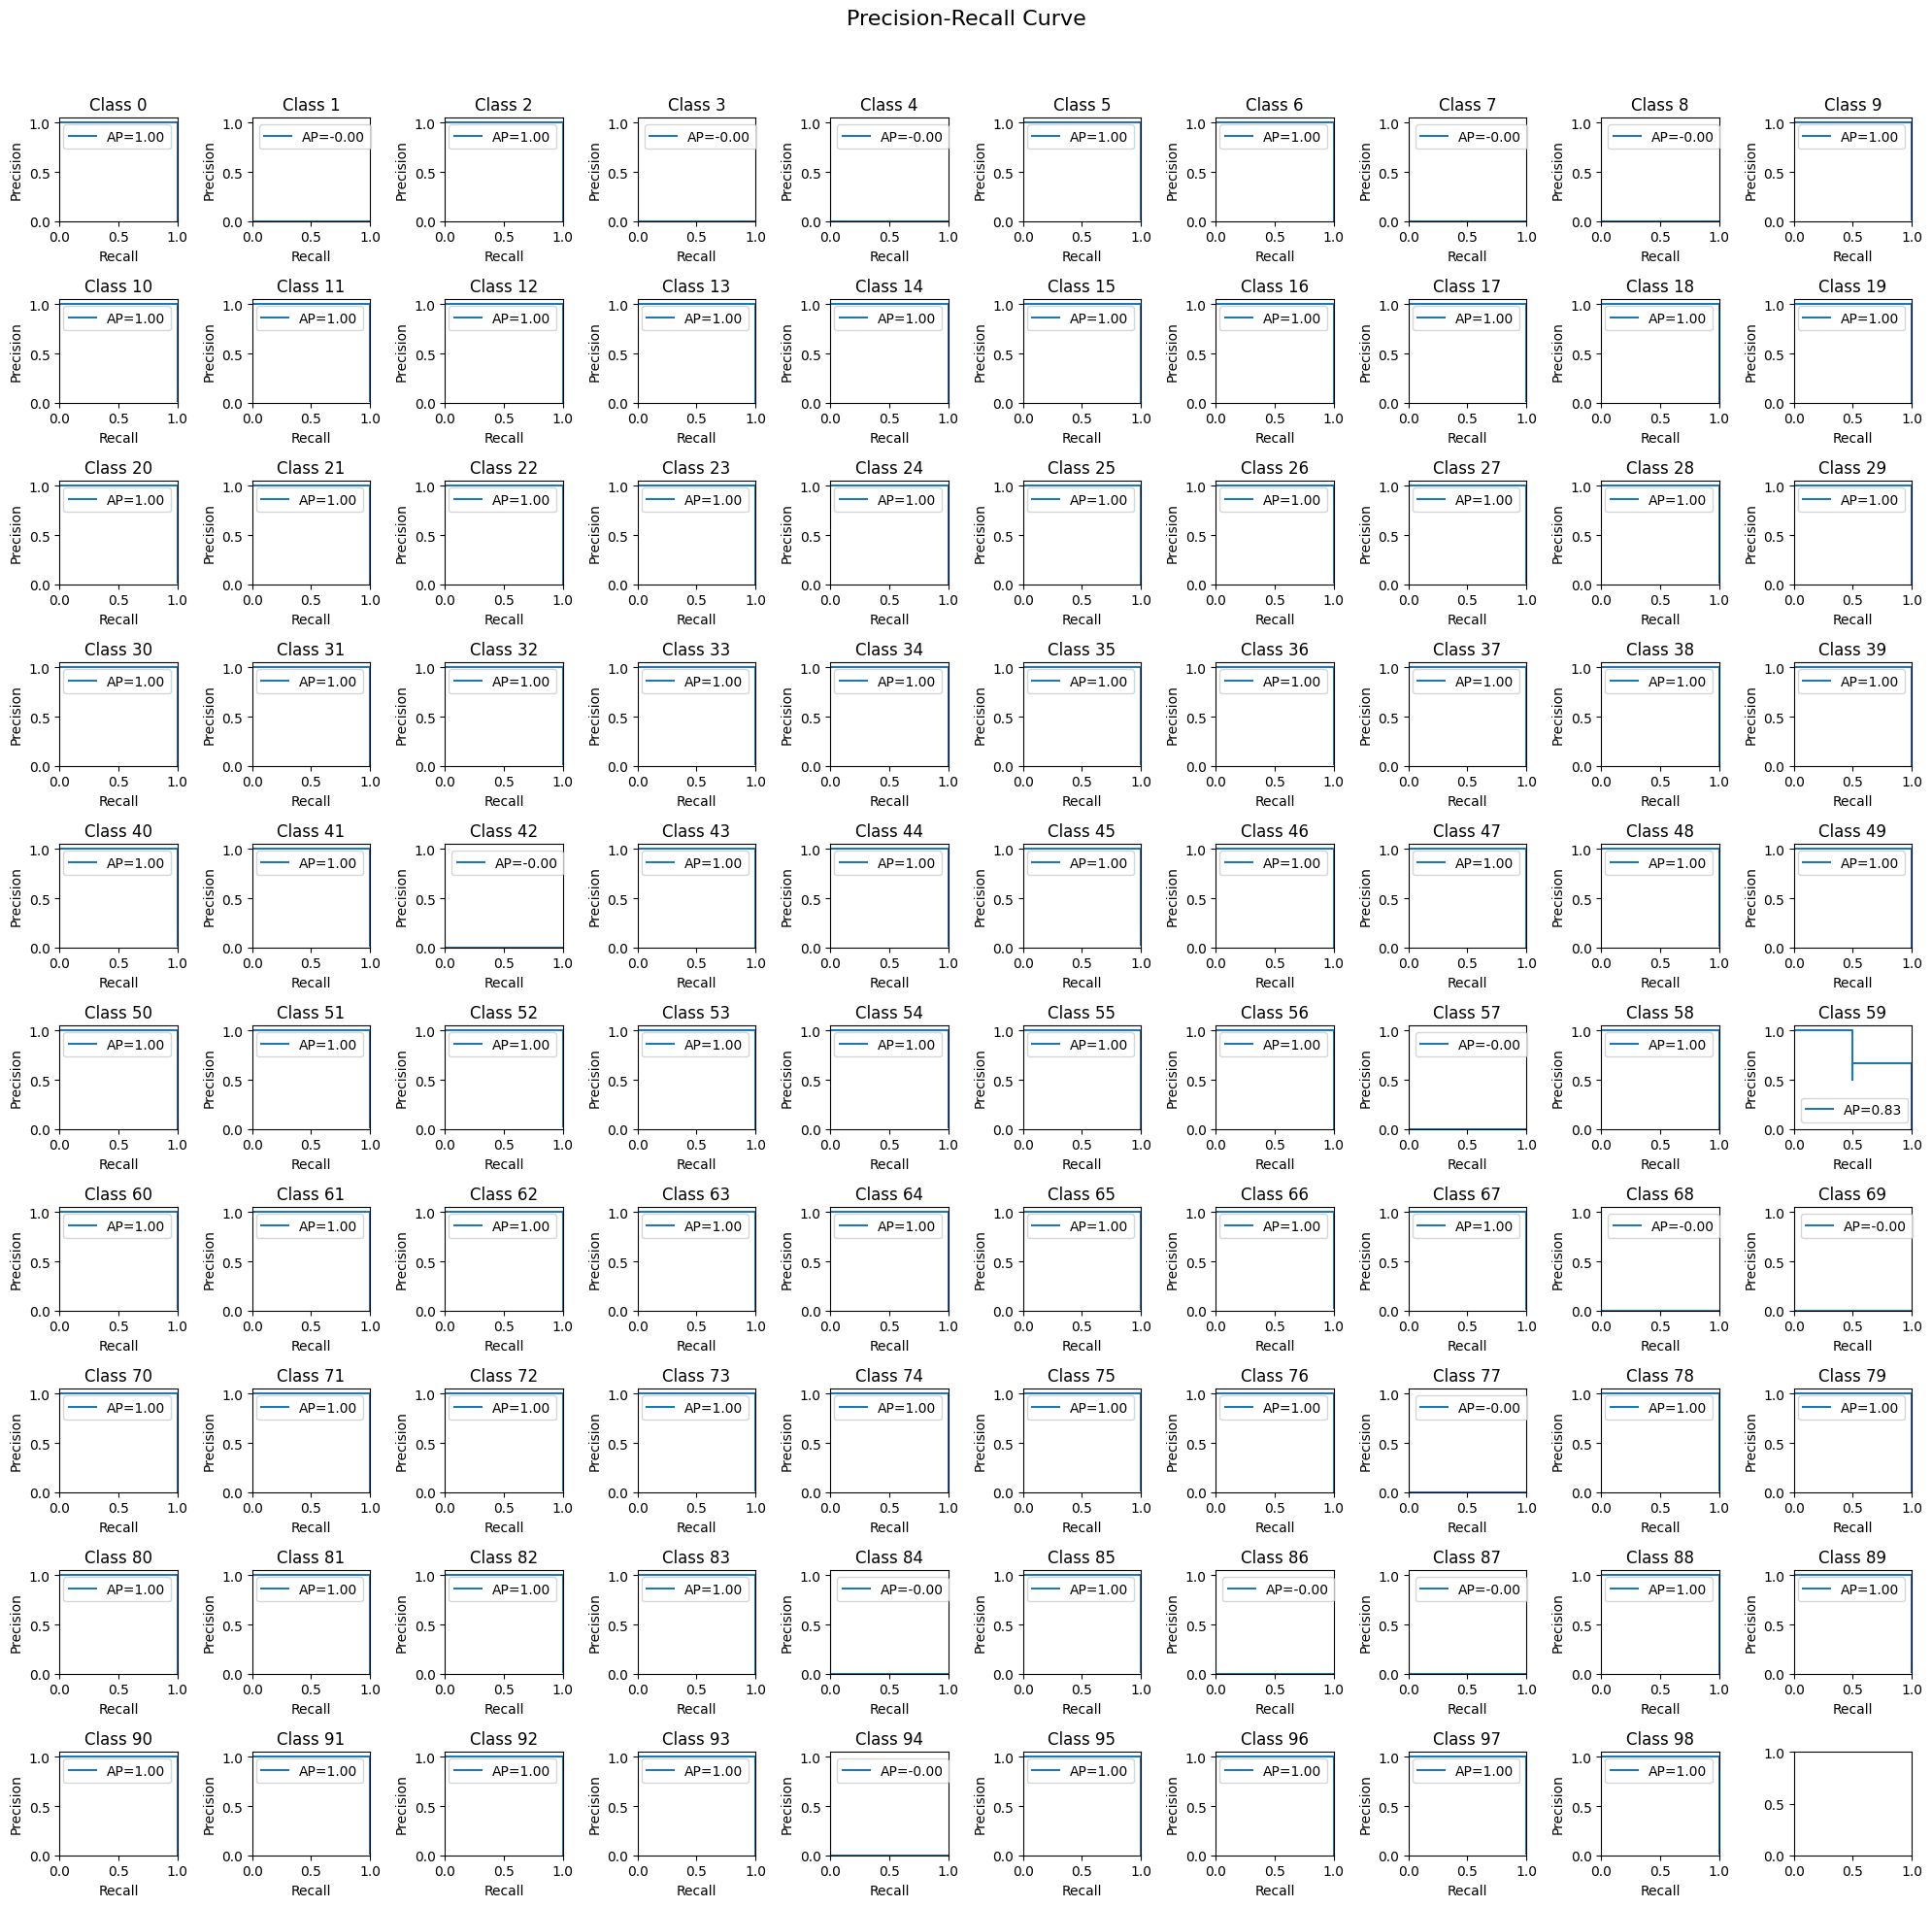

In [39]:
# Binarize the output. Replace 'y' with your validation labels e.g., 'y_val'
y_bin = label_binarize(y_val, classes=list(range(99)))

# Get the predicted probabilities from the best model
y_score = best_model.predict(X_val_reshaped)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Determine grid size for the plots
grid_size = int(np.ceil(np.sqrt(num_classes)))

# Set up figure for ROC plot
fig, axs = plt.subplots(grid_size, grid_size, figsize=(2*grid_size, 2*grid_size))
fig.suptitle('ROC Curve', fontsize=16)
for i, ax in enumerate(fig.axes):
    if i < num_classes:
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Class '+str(i))
        ax.legend(loc="lower right")

plt.tight_layout(rect=[0, 0, 1, 0.96]) # rect parameter ensures the suptitle does not overlap
plt.show()

# Compute Precision-Recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])

# Set up figure for Precision-Recall plot
fig, axs = plt.subplots(grid_size, grid_size, figsize=(2*grid_size, 2*grid_size))
fig.suptitle('Precision-Recall Curve', fontsize=16)
for i, ax in enumerate(fig.axes):
    if i < num_classes:
        ax.step(recall[i], precision[i], where='post', label='AP={0:0.2f}'.format(average_precision[i]))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.0])
        ax.set_title('Class '+str(i))
        ax.legend(loc="best")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

##### Generating output file

In [40]:
# Use the best_model to make predictions using the test_data for up-loading on Kaggle

# Load the test data
test_df = pd.read_csv('./input/test.csv.zip')

# Copy the original Test DataFrame
processed_test_df = test_df.copy()

# Initialize the scaler
scaler = MinMaxScaler()

# Your code seems to suggest that the 'id' column is not a feature for model training.
# Scale numeric columns
numeric_cols = processed_test_df.columns.drop(['id'])
processed_test_df[numeric_cols] = scaler.fit_transform(processed_test_df[numeric_cols])

# Define the reshape function for cnn
def reshape_for_cnn(X, n_channels):
    # Calculate the dimension of the square
    dim = int(np.sqrt(X.shape[1] // n_channels))

    # Reshape the data to (n_samples, dim, dim, n_channels) - suitable for CNN
    X_reshaped = X.values.reshape(-1, dim, dim, n_channels)
    return X_reshaped

# Reshape data for CNN
n_channels = 3 # set the number of channels according to the shape of your data

X_test = processed_test_df.drop(columns=['id'])
X_test_reshaped = reshape_for_cnn(X_test, n_channels)

# Predict the probabilities using the best model from above
test_predictions = best_model.predict(X_test_reshaped)
test_predictions = pd.DataFrame(test_predictions, columns=classes)

# Create submission DataFrame
submission_df = pd.DataFrame({'Id': test_df['id']}).join(test_predictions)

# Save DataFrame to csv
submission_df.to_csv('kaggle_submission_model3.csv', index=False)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In layman's terms, the management/research question of interest is: "**How can we accurately identify the species of a leaf from its image using machine learning**?"

People care about this for several reasons:

1. Environmental Conservation: Knowing the species of a plant can help in tracking biodiversity, protecting endangered species, and managing ecosystems.
2. Agriculture: Farmers and botanists can quickly identify plant species, which is crucial for managing crops, detecting invasive species, or diagnosing plant diseases.
3. Education and Research: Students, researchers, and hobbyists can use this technology to learn more about plants and contribute to citizen science projects.
4. Automation and Efficiency: Automating the identification process saves time and reduces human error, making it easier for professionals and enthusiasts alike to classify plants accurately without needing specialized knowledge.

In essence, accurate leaf classification using machine learning can significantly benefit fields like conservation, agriculture, education, and research, making it a valuable tool in understanding and preserving our natural world.